# Table of Contents
 <p><div class="lev1"><a href="#Initialize-Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev1"><a href="#Subgraph-of-Brain-Systems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Subgraph of Brain Systems</a></div><div class="lev2"><a href="#Focal-vs-Distributed-Subgraphs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Focal vs Distributed Subgraphs</a></div><div class="lev2"><a href="#Formulate-ROI-Dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Formulate ROI Dict</a></div><div class="lev2"><a href="#Convert-ROI-Subgraphs-to-Brain-System-Subgraphs-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert ROI Subgraphs to Brain System Subgraphs</a></div><div class="lev2"><a href="#Between-Task-Subgraph-Contrast-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Between-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Within-Task-Subgraph-Contrast-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Within-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Subgraph-Expression-vs-Behavior-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Subgraph Expression vs Behavior</a></div><div class="lev3"><a href="#Load-Behavioral-Data-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Load Behavioral Data</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-RT-(Hi)-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Predicting High Demand Condition RT (Hi)</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-RT-(Hi-Lo)-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>Predicting High Demand Condition RT (Hi-Lo)</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-Accuracy-(Hi)-2.6.4"><span class="toc-item-num">2.6.4&nbsp;&nbsp;</span>Predicting High Demand Condition Accuracy (Hi)</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-Accuracy-(Hi-Lo)-2.6.5"><span class="toc-item-num">2.6.5&nbsp;&nbsp;</span>Predicting High Demand Condition Accuracy (Hi-Lo)</a></div>

# Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis_Notebooks/')

path_Remotes = '/Users/akhambhati/Remotes'
path_CoreData = path_Remotes + '/CORE.fMRI_cogcontrol.medaglia'
path_RsrchData = path_Remotes + '/RSRCH.NMF_CogControl'
path_InpData = path_RsrchData + '/e02-FuncSubg'
path_ExpData = path_RsrchData + '/e04-FuncSubg_Dynamics'

for path in [path_CoreData, path_RsrchData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/Users/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Subgraph of Brain Systems

In [2]:
df_nmf = np.load('{}/NMF_Consensus.npz'.format(path_InpData), mmap_mode='r')
fac_subnet = df_nmf['fac_subnet']
fac_coef = df_nmf['fac_coef']
n_fac = fac_subnet.shape[0]
n_conn = fac_subnet.shape[1]
n_obs = fac_coef.shape[1]

## Focal vs Distributed Subgraphs

(0, 54)

/Users/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


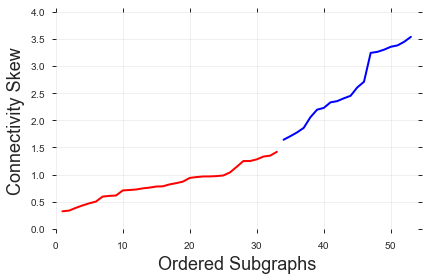

In [3]:
real_subg_skew = np.array([stats.skew(subg) for subg in fac_subnet])
real_ix = np.argsort(real_subg_skew)

n_null = 10000
rnd_coef = np.random.uniform(size=(n_null, n_fac))
rnd_subnet = np.dot(rnd_coef, fac_subnet)

rnd_subg_skew = np.array([stats.skew(subg) for subg in rnd_subnet])
rnd_ix = np.argsort(rnd_subg_skew)

low_ix = np.flatnonzero(real_subg_skew[real_ix] < np.min(rnd_subg_skew))
mid_ix = np.flatnonzero((real_subg_skew[real_ix] >= np.min(rnd_subg_skew)) &
                        (real_subg_skew[real_ix] <= np.max(rnd_subg_skew)))
high_ix = np.flatnonzero(real_subg_skew[real_ix] > np.max(rnd_subg_skew))

%matplotlib inline
plt.figure()
ax = plt.subplot(111)
ax.plot(low_ix, real_subg_skew[real_ix][low_ix], color='b')
ax.plot(mid_ix, real_subg_skew[real_ix][mid_ix], color='r')
ax.plot(high_ix, real_subg_skew[real_ix][high_ix], color='b')
ax.set_xlabel('Ordered Subgraphs')
ax.set_ylabel('Connectivity Skew')
ax.set_xlim([0, n_fac])

## Formulate ROI Dict

In [4]:
df_parcel = pd.read_csv('{}/LausanneScale125.csv'.format(path_CoreData))

all_roi_names = []

roi_dict = {}
for lbl_id, lbl_roi, lbl_hemi in zip(df_parcel.Label_ID, df_parcel.ROI, df_parcel.Hemisphere):
    roi_name = '{}_{}'.format(lbl_hemi, lbl_roi.split('_')[0])
    #roi_name = lbl_roi.split('_')[0]
    
    if roi_name not in all_roi_names:
        all_roi_names.append(roi_name)

    try:
        roi_dict[roi_name]
    except KeyError:
        roi_dict[roi_name] = []

    roi_dict[roi_name].append(lbl_id-1)
n_roi = len(all_roi_names)
n_conn_roi = int(n_roi*(n_roi-1)*0.5)

## Convert ROI Subgraphs to Brain System Subgraphs

In [5]:
bs_fac_subnet = np.zeros((n_fac, n_conn_roi))
for fac_i, subg in enumerate(fac_subnet):
    adj = conv_cfg_vec_to_adj_matr(subg)
    
    tmp_subnet = np.zeros((1, n_roi, n_roi))
    for ij_ii, ij_roi in enumerate(all_roi_names):
        for ik_ii, ik_roi in enumerate(all_roi_names):
            
            mean_conn = adj[roi_dict[ij_roi], :][:, roi_dict[ik_roi]].mean()
            tmp_subnet[0, ij_ii, ik_ii] = mean_conn
    bs_fac_subnet[fac_i, :] = conv_adj_matr_to_cfg_matr(tmp_subnet)[0, :]

## Between-Task Subgraph Contrast

****************************** Subgraph 7 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

    Pos-Stroop-Navon: ts: -4.530e+00 pval: 1.076e-04 sig: *
    Neg-Stroop-Navon: ts: 2.495e+00 pval: 1.900e-02 sig: 


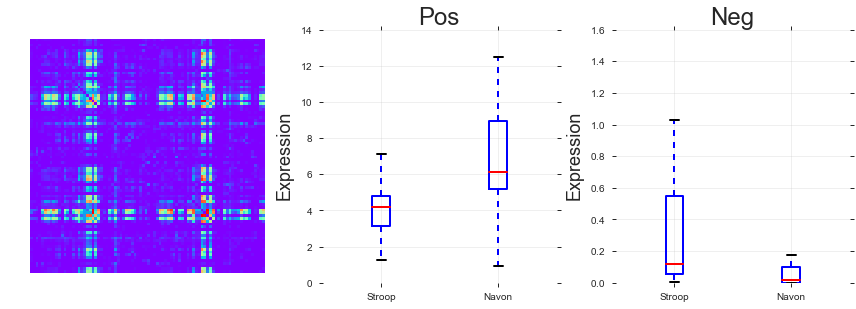





****************************** Subgraph 10 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

    Pos-Stroop-Navon: ts: -9.508e+00 pval: 4.142e-10 sig: *
    Neg-Stroop-Navon: ts: 2.472e+00 pval: 2.005e-02 sig: 


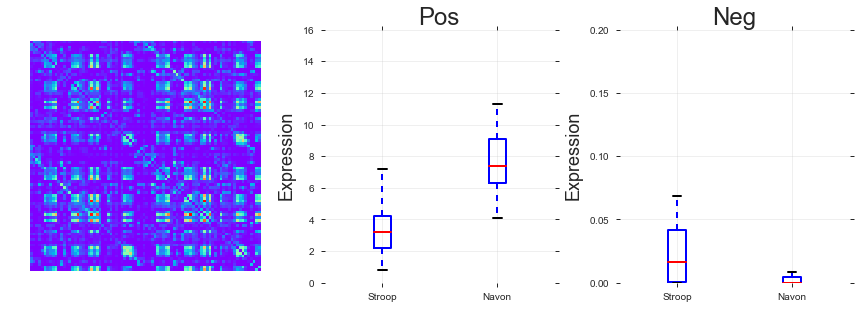





****************************** Subgraph 13 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

    Pos-Stroop-Navon: ts: 2.534e+00 pval: 1.737e-02 sig: 
    Neg-Stroop-Navon: ts: -2.911e+00 pval: 7.133e-03 sig: *


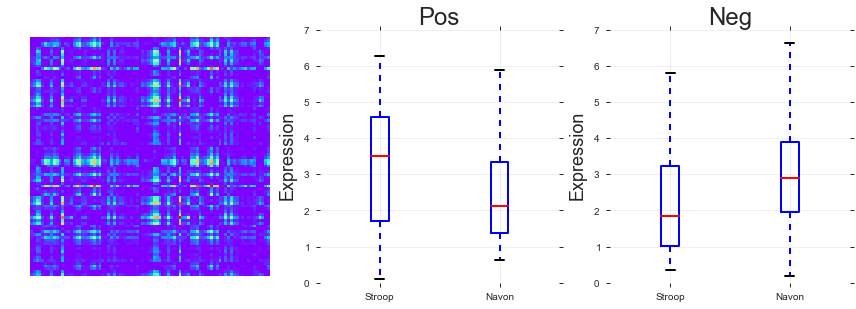





****************************** Subgraph 17 ******************************
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    RH_caudalmiddlefrontal
    RH_middletemporal
    RH_inferiorparietal
    RH_parsopercularis

    Pos-Stroop-Navon: ts: -4.041e+00 pval: 3.976e-04 sig: *
    Neg-Stroop-Navon: ts: 4.547e+00 pval: 1.029e-04 sig: *


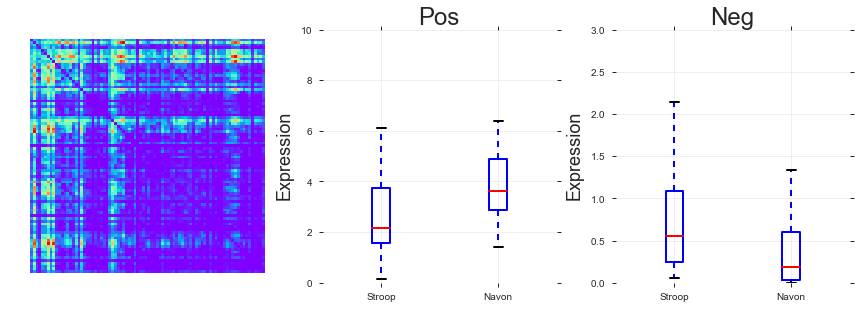





****************************** Subgraph 19 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Pos-Stroop-Navon: ts: 4.560e+00 pval: 9.926e-05 sig: *
    Neg-Stroop-Navon: ts: -1.276e+00 pval: 2.129e-01 sig: 


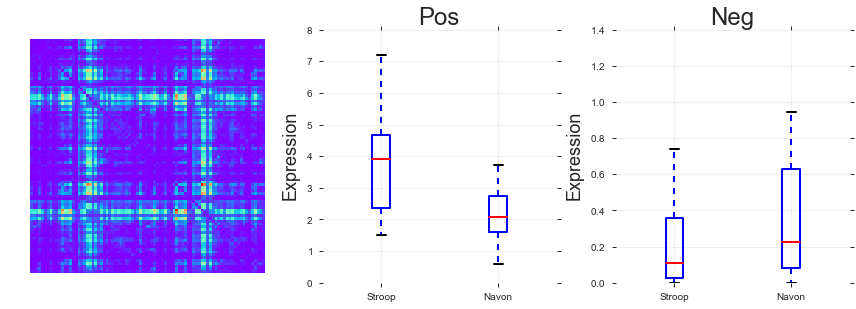

In [18]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Pos': {'Stroop': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                   'Navon': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon']},
           'Neg': {'Stroop': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop'],
                   'Navon': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Pos', 'Neg']
key_order = ['Stroop', 'Navon']

#sel_fac_ix = xrange(n_fac)
sel_fac_ix = np.sort(real_ix[high_ix])

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)

            mean_subj_coef = 0.5*(np.mean(subj_hi, axis=1) + np.mean(subj_lo, axis=1))
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
        
        for key_pair in [[0,1]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv,
                                          'sig': ''})
            
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_between_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if fac_stat['pval'] < adj_alpha:
                fac_stat['sig'] = '*'
                sel_fac_between_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_between_sig = np.unique(sel_fac_between_sig)

# Plot each result
for fac_ix in sel_fac_between_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2, 3]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        #ax.yaxis.set_ticks_position('left')
        #ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %s-%s: ts: %0.3e pval: %0.3e sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))        
            
    plt.show()
    print('\n\n\n')

## Within-Task Subgraph Contrast

****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

      Stroop_Pos: Rs-Lo: ts: -4.524e-01 pval: 6.546e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -2.671e+00 pval: 1.264e-02 sig: 
      Stroop_Pos: Lo-Hi: ts: -2.681e+00 pval: 1.236e-02 sig: 

       Navon_Pos: Rs-Lo: ts: -3.170e+00 pval: 3.769e-03 sig: *
       Navon_Pos: Rs-Hi: ts: -3.107e+00 pval: 4.408e-03 sig: *
       Navon_Pos: Lo-Hi: ts: 6.538e-01 pval: 5.188e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -1.388e+00 pval: 1.764e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: -1.128e+00 pval: 2.691e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 3.735e-01 pval: 7.117e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -6.617e-01 pval: 5.138e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -1.940e+00 pval: 6.287e-02 sig: 
       Navon_Neg: Lo-Hi: ts: -8.627e-01 pval: 3.959e-01 sig: 



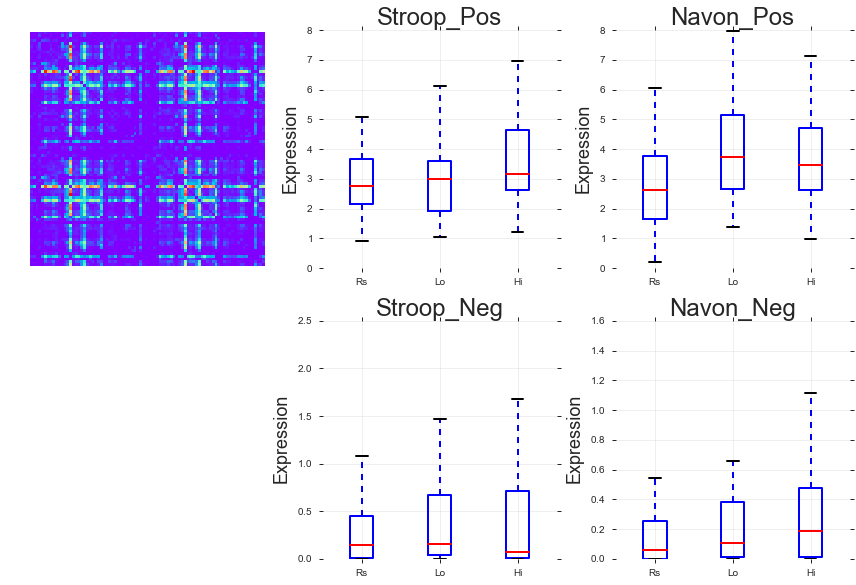





****************************** Subgraph 7 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

      Stroop_Pos: Rs-Lo: ts: -2.925e+00 pval: 6.893e-03 sig: 
      Stroop_Pos: Rs-Hi: ts: -3.440e+00 pval: 1.907e-03 sig: *
      Stroop_Pos: Lo-Hi: ts: -7.847e-01 pval: 4.394e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -4.568e+00 pval: 9.720e-05 sig: *
       Navon_Pos: Rs-Hi: ts: -6.075e+00 pval: 1.738e-06 sig: *
       Navon_Pos: Lo-Hi: ts: -1.931e+00 pval: 6.404e-02 sig: 

      Stroop_Neg: Rs-Lo: ts: -1.546e-01 pval: 8.783e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 1.264e+00 pval: 2.171e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 1.400e+00 pval: 1.729e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 3.290e-01 pval: 7.447e-01 sig: 
       Navon_Neg: Rs-Hi: ts: 6.543e-02 pval: 9.483e-01 sig: 
       Navon_Neg: Lo-Hi: ts: -5.509e-01 pval: 5.862e-01 sig: 



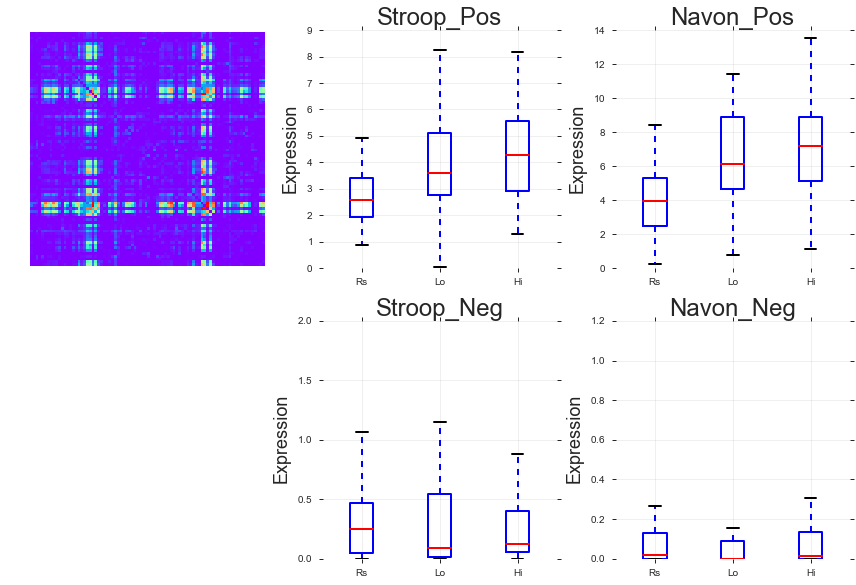





****************************** Subgraph 8 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

      Stroop_Pos: Rs-Lo: ts: -7.491e-01 pval: 4.603e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -4.446e+00 pval: 1.350e-04 sig: *
      Stroop_Pos: Lo-Hi: ts: -4.733e+00 pval: 6.245e-05 sig: *

       Navon_Pos: Rs-Lo: ts: -4.147e+00 pval: 2.998e-04 sig: *
       Navon_Pos: Rs-Hi: ts: -4.039e+00 pval: 3.995e-04 sig: *
       Navon_Pos: Lo-Hi: ts: -2.018e-01 pval: 8.416e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -8.408e-01 pval: 4.079e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 1.788e+00 pval: 8.494e-02 sig: 
      Stroop_Neg: Lo-Hi: ts: 2.078e+00 pval: 4.739e-02 sig: 

       Navon_Neg: Rs-Lo: ts: 1.233e+00 pval: 2.282e-01 sig: 
       Navon_Neg: Rs-Hi: ts: 9.812e-01 pval: 3.352e-01 sig: 
       Navon_Neg: Lo-Hi: ts: -4.977e-04 pval: 9.996e-01 sig: 



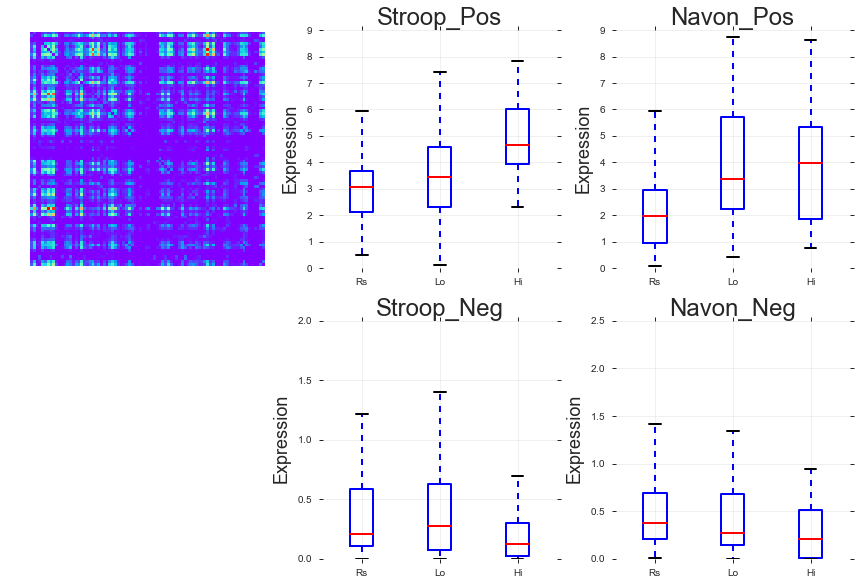





****************************** Subgraph 9 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

      Stroop_Pos: Rs-Lo: ts: -2.188e+00 pval: 3.752e-02 sig: 
      Stroop_Pos: Rs-Hi: ts: -3.833e+00 pval: 6.864e-04 sig: *
      Stroop_Pos: Lo-Hi: ts: -2.150e+00 pval: 4.065e-02 sig: 

       Navon_Pos: Rs-Lo: ts: -3.384e+00 pval: 2.201e-03 sig: *
       Navon_Pos: Rs-Hi: ts: -4.508e+00 pval: 1.144e-04 sig: *
       Navon_Pos: Lo-Hi: ts: -1.958e+00 pval: 6.066e-02 sig: 

      Stroop_Neg: Rs-Lo: ts: 1.317e-01 pval: 8.962e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 8.019e-01 pval: 4.296e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 9.631e-01 pval: 3.441e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 3.128e-01 pval: 7.568e-01 sig: 
       Navon_Neg: Rs-Hi: ts: 9.414e-01 pval: 3.549e-01 sig: 
       Navon_Neg: Lo-Hi: ts: 8.604e-01 pval: 3.971e-01 sig: 



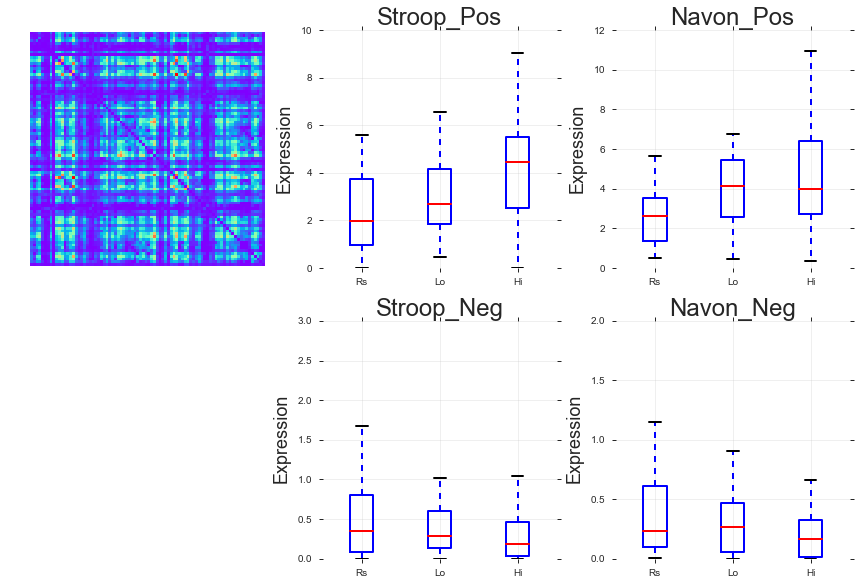





****************************** Subgraph 10 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

      Stroop_Pos: Rs-Lo: ts: -1.392e+00 pval: 1.754e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -3.411e+00 pval: 2.052e-03 sig: *
      Stroop_Pos: Lo-Hi: ts: -2.547e+00 pval: 1.687e-02 sig: 

       Navon_Pos: Rs-Lo: ts: -4.961e+00 pval: 3.380e-05 sig: *
       Navon_Pos: Rs-Hi: ts: -8.449e+00 pval: 4.625e-09 sig: *
       Navon_Pos: Lo-Hi: ts: -3.533e+00 pval: 1.501e-03 sig: *

      Stroop_Neg: Rs-Lo: ts: 9.063e-01 pval: 3.728e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 1.475e+00 pval: 1.517e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 9.037e-01 pval: 3.741e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 1.475e+00 pval: 1.517e-01 sig: 
       Navon_Neg: Rs-Hi: ts: 2.894e+00 pval: 7.443e-03 sig: 
       Navon_Neg: Lo-Hi: ts: 1.416e+00 pval: 1.681e-01 sig: 



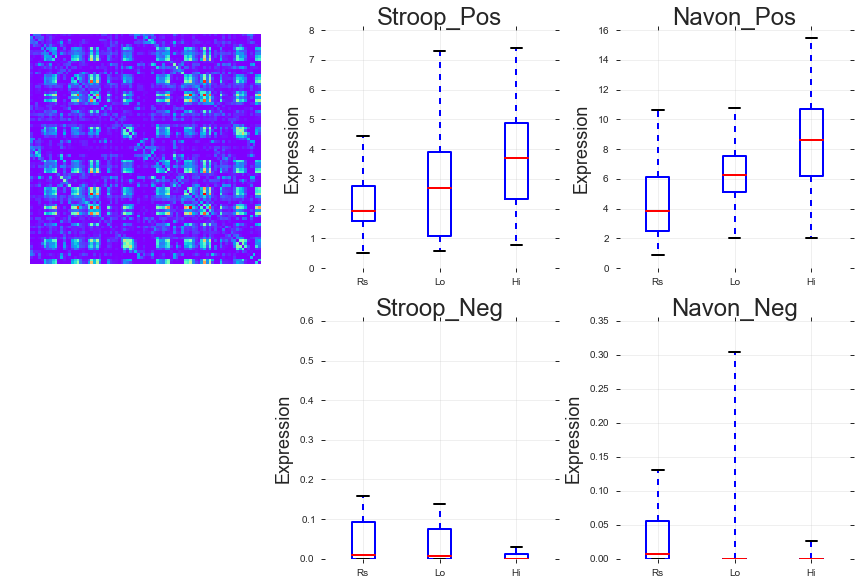





****************************** Subgraph 11 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

      Stroop_Pos: Rs-Lo: ts: -1.100e+00 pval: 2.809e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -2.693e+00 pval: 1.202e-02 sig: 
      Stroop_Pos: Lo-Hi: ts: -2.013e+00 pval: 5.419e-02 sig: 

       Navon_Pos: Rs-Lo: ts: -4.963e+00 pval: 3.362e-05 sig: *
       Navon_Pos: Rs-Hi: ts: -2.959e+00 pval: 6.355e-03 sig: 
       Navon_Pos: Lo-Hi: ts: 1.288e+00 pval: 2.087e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -1.579e+00 pval: 1.260e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: -9.682e-01 pval: 3.415e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 2.916e-01 pval: 7.728e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -6.593e-01 pval: 5.153e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -1.442e+00 pval: 1.608e-01 sig: 
       Navon_Neg: Lo-Hi: ts: -1.476e+00 pval: 1.516e-01 sig: 



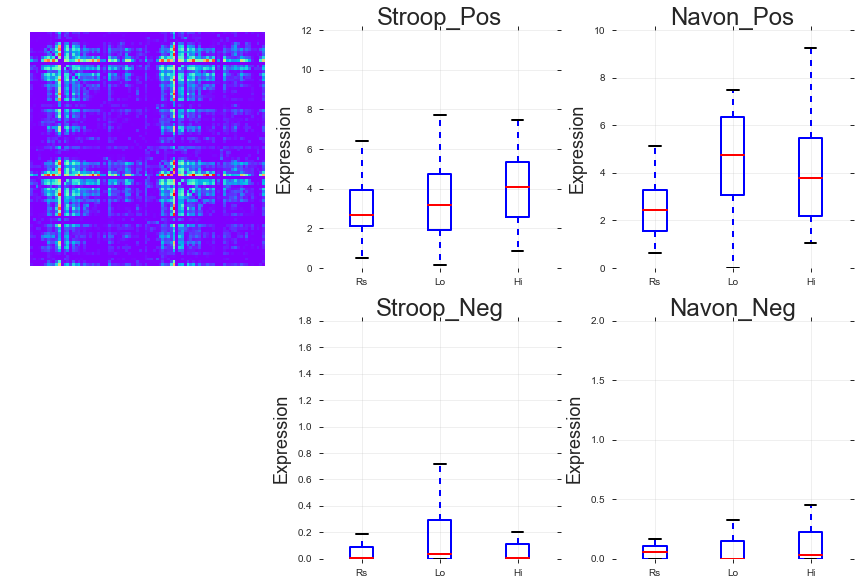





****************************** Subgraph 13 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

      Stroop_Pos: Rs-Lo: ts: 1.310e+00 pval: 2.014e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: 5.596e-01 pval: 5.803e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: -8.989e-01 pval: 3.766e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -8.390e-01 pval: 4.089e-01 sig: 
       Navon_Pos: Rs-Hi: ts: 1.428e-01 pval: 8.875e-01 sig: 
       Navon_Pos: Lo-Hi: ts: 9.675e-01 pval: 3.419e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -2.510e+00 pval: 1.839e-02 sig: 
      Stroop_Neg: Rs-Hi: ts: -3.281e+00 pval: 2.851e-03 sig: *
      Stroop_Neg: Lo-Hi: ts: 4.632e-02 pval: 9.634e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -2.349e+00 pval: 2.638e-02 sig: 
       Navon_Neg: Rs-Hi: ts: -3.316e+00 pval: 2.613e-03 sig: *
       Navon_Neg: Lo-Hi: ts: -1.222e+00 pval: 2.324e-01 sig: 



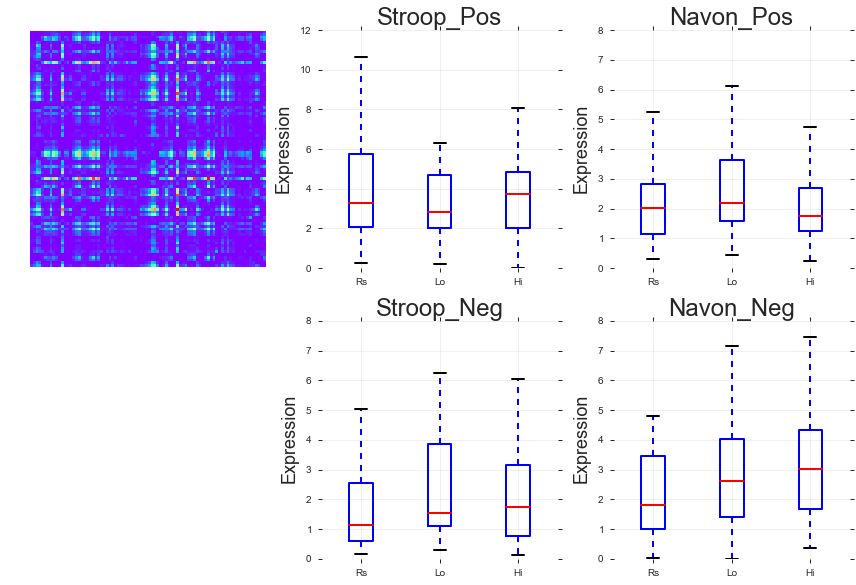





****************************** Subgraph 14 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

      Stroop_Pos: Rs-Lo: ts: -1.679e+00 pval: 1.046e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -9.680e-02 pval: 9.236e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: 1.823e+00 pval: 7.932e-02 sig: 

       Navon_Pos: Rs-Lo: ts: -2.846e+00 pval: 8.348e-03 sig: 
       Navon_Pos: Rs-Hi: ts: -3.197e+00 pval: 3.528e-03 sig: *
       Navon_Pos: Lo-Hi: ts: -1.393e+00 pval: 1.749e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: 9.379e-01 pval: 3.566e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 3.022e-01 pval: 7.648e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: -8.889e-01 pval: 3.819e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -2.047e-02 pval: 9.838e-01 sig: 
       Navon_Neg: Rs-Hi: ts: 2.502e-01 pval: 8.043e-01 sig: 
       Navon_Neg: Lo-Hi: ts: 2.376e-01 pval: 8.140e-01 sig: 



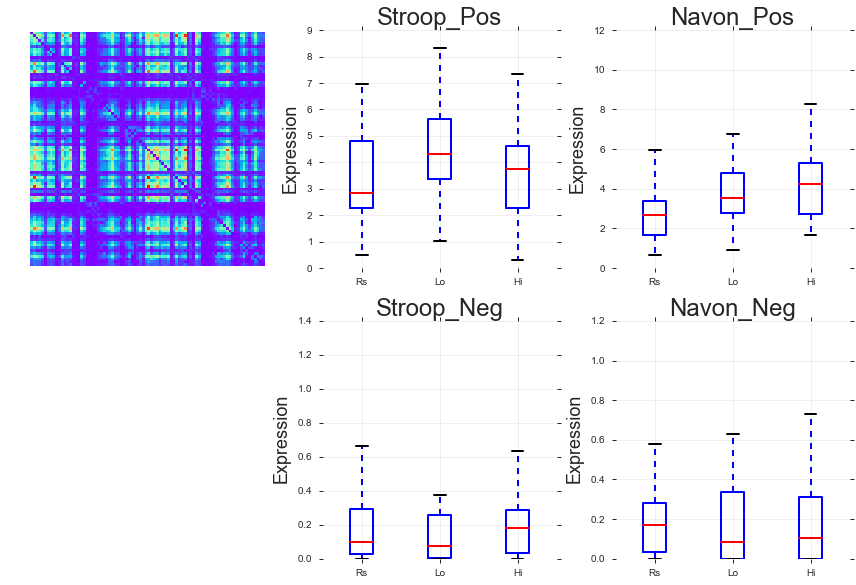





****************************** Subgraph 16 ******************************
    RH_frontalpole
    RH_lateralorbitofrontal
    LH_lateralorbitofrontal
    RH_parsorbitalis
    LH_frontalpole
    LH_parsorbitalis

      Stroop_Pos: Rs-Lo: ts: -2.091e+00 pval: 4.606e-02 sig: 
      Stroop_Pos: Rs-Hi: ts: -1.362e+00 pval: 1.844e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: 2.196e-01 pval: 8.278e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -2.313e+00 pval: 2.859e-02 sig: 
       Navon_Pos: Rs-Hi: ts: -1.922e+00 pval: 6.516e-02 sig: 
       Navon_Pos: Lo-Hi: ts: 1.997e-01 pval: 8.432e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: 2.997e+00 pval: 5.793e-03 sig: 
      Stroop_Neg: Rs-Hi: ts: 3.468e+00 pval: 1.776e-03 sig: *
      Stroop_Neg: Lo-Hi: ts: -6.821e-01 pval: 5.010e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 3.233e+00 pval: 3.218e-03 sig: *
       Navon_Neg: Rs-Hi: ts: 2.234e+00 pval: 3.393e-02 sig: 
       Navon_Neg: Lo-Hi: ts: -2.280e-01 pval: 8.213e-01 sig: 



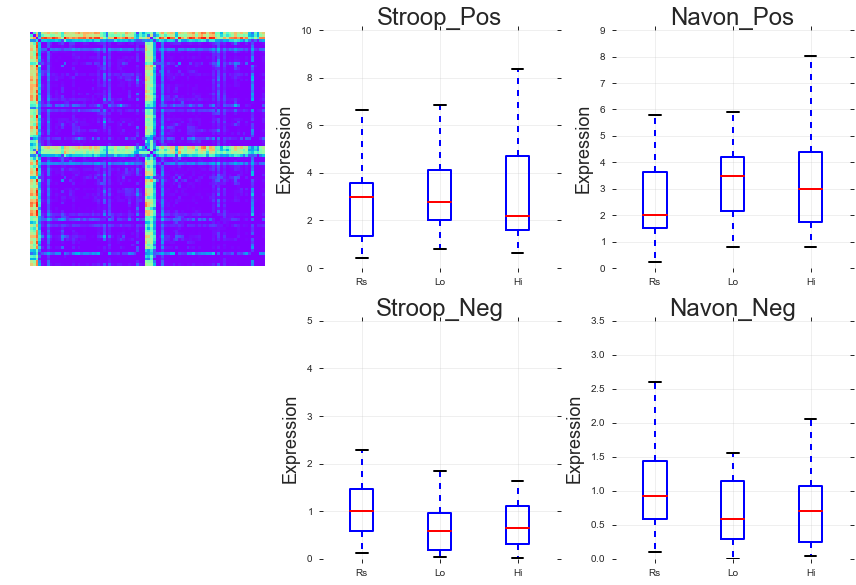





****************************** Subgraph 19 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

      Stroop_Pos: Rs-Lo: ts: -3.194e+00 pval: 3.550e-03 sig: *
      Stroop_Pos: Rs-Hi: ts: -3.145e+00 pval: 4.014e-03 sig: *
      Stroop_Pos: Lo-Hi: ts: 8.456e-01 pval: 4.052e-01 sig: 

       Navon_Pos: Rs-Lo: ts: 4.099e-01 pval: 6.851e-01 sig: 
       Navon_Pos: Rs-Hi: ts: 2.729e+00 pval: 1.103e-02 sig: 
       Navon_Pos: Lo-Hi: ts: 1.925e+00 pval: 6.479e-02 sig: 

      Stroop_Neg: Rs-Lo: ts: 9.935e-01 pval: 3.293e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 5.604e-01 pval: 5.798e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: -3.460e-01 pval: 7.320e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -6.482e-01 pval: 5.223e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -3.278e+00 pval: 2.876e-03 sig: *
       Navon_Neg: Lo-Hi: ts: -1.669e+00 pval: 1.068e-01 sig: 



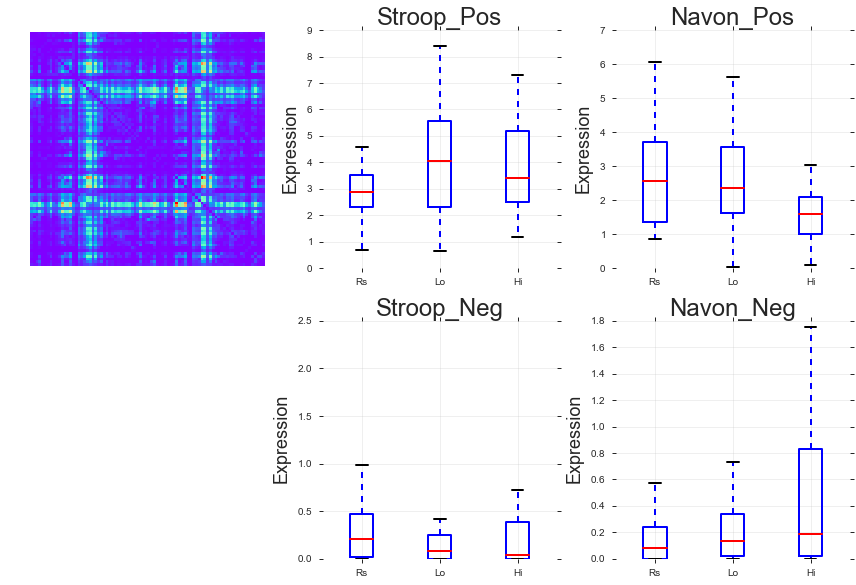

In [19]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop_Pos': {'Rs': ['adj_rs_pos_Stroop'],
                          'Lo': ['adj_lo_pos_Stroop'],
                          'Hi': ['adj_hi_pos_Stroop']},
           'Navon_Pos' : {'Rs': ['adj_rs_pos_Navon'],
                          'Lo': ['adj_lo_pos_Navon'],
                          'Hi': ['adj_hi_pos_Navon']},
           'Stroop_Neg': {'Rs': ['adj_rs_neg_Stroop'],
                          'Lo': ['adj_lo_neg_Stroop'],
                          'Hi': ['adj_hi_neg_Stroop']},
           'Navon_Neg' : {'Rs': ['adj_rs_neg_Navon'],
                          'Lo': ['adj_lo_neg_Navon'],
                          'Hi': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop_Pos', 'Navon_Pos', 'Stroop_Neg', 'Navon_Neg']
key_order = ['Rs', 'Lo', 'Hi']

#sel_fac_ix = xrange(n_fac)
sel_fac_ix = np.sort(real_ix[high_ix])

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)

            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
            
        for key_pair in [[0,1], [0,2], [1,2]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv,
                                          'sig': ''})        
        
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_within_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if fac_stat['pval'] < adj_alpha:
                fac_stat['sig'] = '*'
                sel_fac_within_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_within_sig = np.unique(sel_fac_within_sig)

# Plot each result
for fac_ix in sel_fac_within_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        #ax.yaxis.set_ticks_position('left')
        #ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %12s: %s: ts: %3.3e pval: %3.3e sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))
        print('')
            
    plt.show()
    print('\n\n\n')

## Subgraph Expression vs Behavior

### Load Behavioral Data

In [20]:
df_beh = io.loadmat('{}/BehavioralData_CogControlCorrect.mat'.format(path_CoreData))

stroop_lbl = [lbl[0] for lbl in df_beh['StroopLabels'][0]]
navon_lbl = [lbl[0] for lbl in df_beh['NavonLabels'][0]]
stroop_beh = df_beh['StroopCorrectOnly']
navon_beh = df_beh['NavonCorrectOnly']

# Removed subjects
bad_subj_ix = [1, 6]
good_subj_ix = np.setdiff1d(np.arange(stroop_beh.shape[0]), bad_subj_ix)

# Excessive movement
stroop_move = io.loadmat('{}/StroopMove.mat'.format(path_CoreData))['move'][:, 0]
navon_move = io.loadmat('{}/NavonMove.mat'.format(path_CoreData))['move'][:, 0]

stroop_acc = stroop_beh[good_subj_ix, 1]
navon_acc = navon_beh[good_subj_ix, 1]

stroop_interf = stroop_beh[good_subj_ix, 5]
navon_interf = navon_beh[good_subj_ix, 5]

stroop_nointerf = stroop_beh[good_subj_ix, 7]
navon_nointerf = navon_beh[good_subj_ix, 7]

stroop_cost = stroop_interf-stroop_nointerf
navon_cost = navon_interf-navon_nointerf



print('Stroop Labels: {}'.format(stroop_lbl))
print('Navon Labels: {}'.format(navon_lbl))

Stroop Labels: [u'Total Accuracy', u'Interference Accuracy', u'NoInterference Accuracy', u'MeanRT', u'MedianRT', u'InterferenceMeanRT', u'InterferenceMedianRT', u'NoInterferenceMeanRT', u'NoInterferenceMedianRT', u'InterferenceMedianRTMinusMeanRT']
Navon Labels: [u'Total Accuracy', u'ShiftingAccuracy', u'NoShiftingAccuracy', u'MeanRT', u'MedianRT', u'ShiftingMeanRT', u'ShiftingMedianRT', u'NoShiftingMeanRT', u'NoShiftingMedianRT', u'ProportionTotalNonResponses']


### Predicting High Demand Condition RT (Hi)

****************************** Subgraph 3 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

    Stroop: Hi_Pos: rho: -0.51014 pval: 0.00555 sig: 
    Stroop: Hi_Neg: rho: 0.37598 pval: 0.04863 sig: 
    Navon: Hi_Pos: rho: 0.06423 pval: 0.74540 sig: 
    Navon: Hi_Neg: rho: -0.14911 pval: 0.44889 sig: 


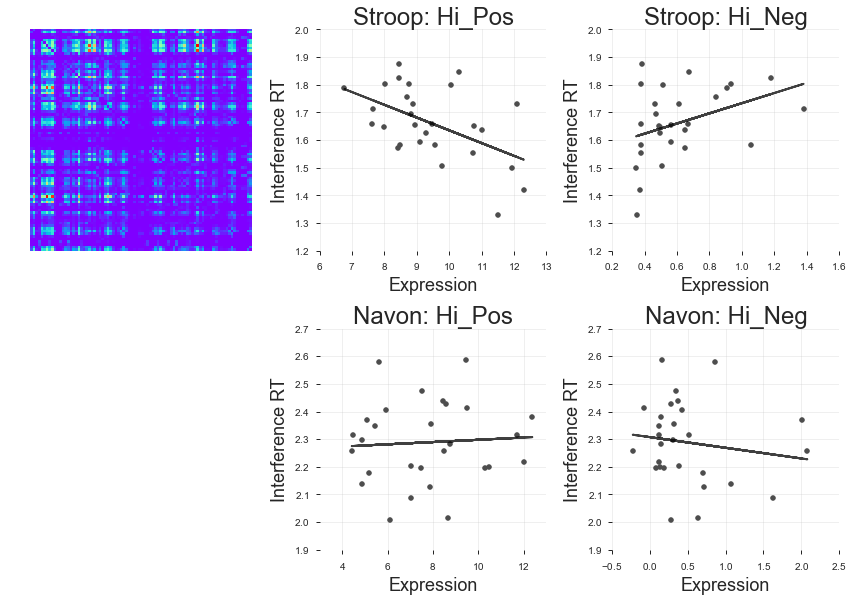





****************************** Subgraph 6 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

    Stroop: Hi_Pos: rho: -0.24742 pval: 0.20431 sig: 
    Stroop: Hi_Neg: rho: 0.09779 pval: 0.62057 sig: 
    Navon: Hi_Pos: rho: -0.13388 pval: 0.49701 sig: 
    Navon: Hi_Neg: rho: 0.43791 pval: 0.01977 sig: 


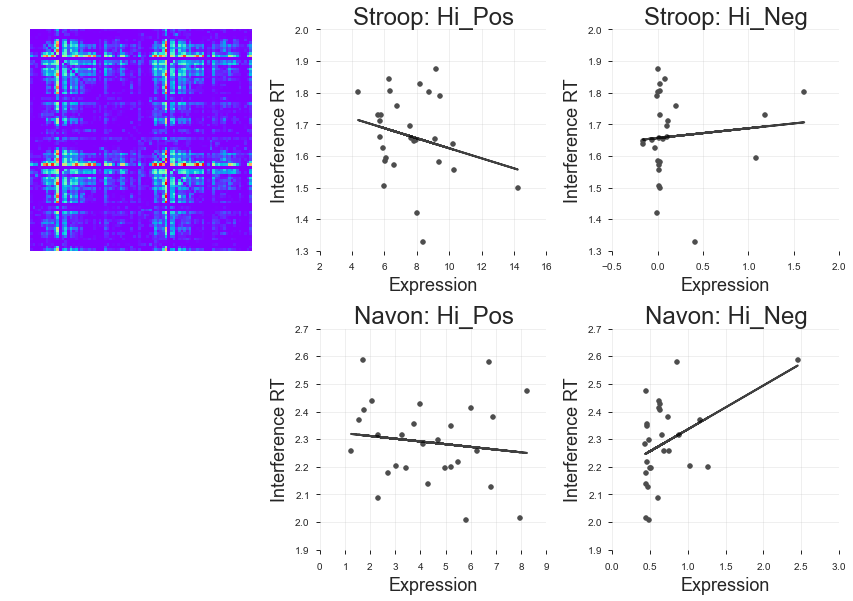





****************************** Subgraph 8 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

    Stroop: Hi_Pos: rho: 0.11399 pval: 0.56355 sig: 
    Stroop: Hi_Neg: rho: -0.33528 pval: 0.08113 sig: 
    Navon: Hi_Pos: rho: -0.04945 pval: 0.80266 sig: 
    Navon: Hi_Neg: rho: 0.25034 pval: 0.19884 sig: 


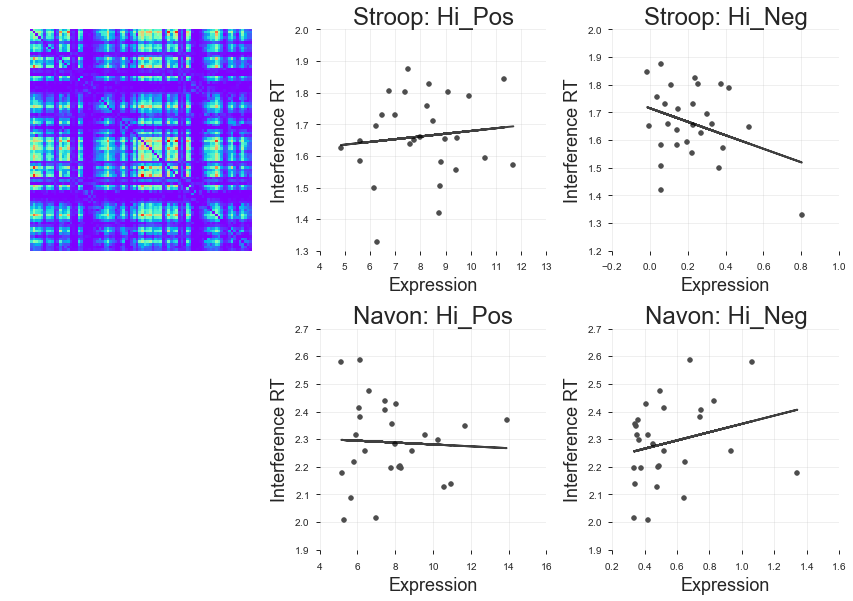





****************************** Subgraph 5 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

    Stroop: Hi_Pos: rho: -0.21626 pval: 0.26902 sig: 
    Stroop: Hi_Neg: rho: 0.14760 pval: 0.45354 sig: 
    Navon: Hi_Pos: rho: 0.01302 pval: 0.94758 sig: 
    Navon: Hi_Neg: rho: -0.02954 pval: 0.88137 sig: 


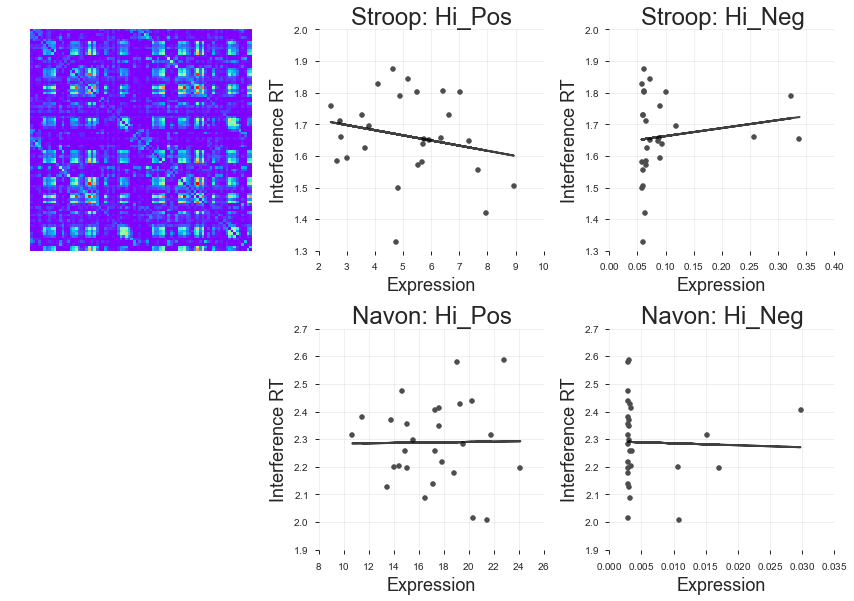





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

    Stroop: Hi_Pos: rho: -0.11453 pval: 0.56170 sig: 
    Stroop: Hi_Neg: rho: 0.19437 pval: 0.32164 sig: 
    Navon: Hi_Pos: rho: -0.04209 pval: 0.83161 sig: 
    Navon: Hi_Neg: rho: 0.19982 pval: 0.30798 sig: 


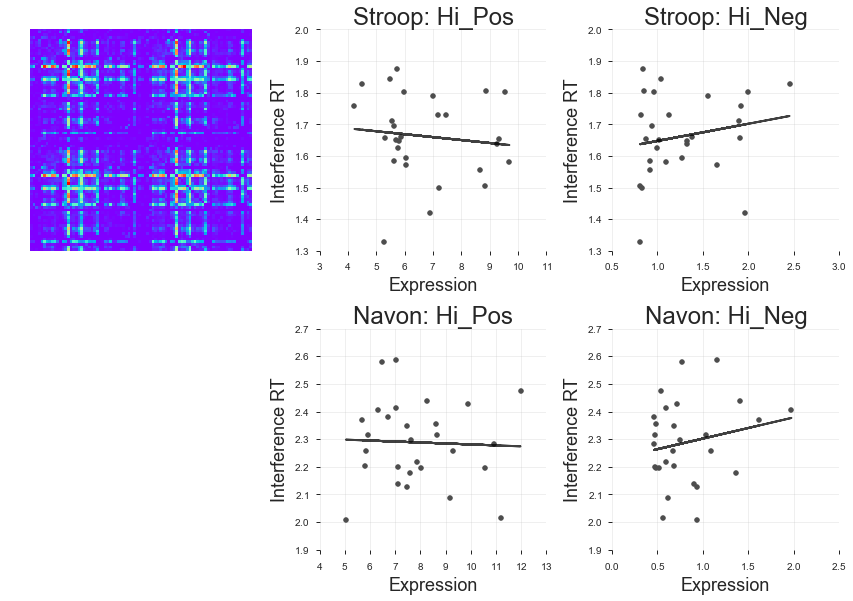





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: -0.01709 pval: 0.93121 sig: 
    Stroop: Hi_Neg: rho: 0.19376 pval: 0.32318 sig: 
    Navon: Hi_Pos: rho: -0.16679 pval: 0.39626 sig: 
    Navon: Hi_Neg: rho: 0.10866 pval: 0.58205 sig: 


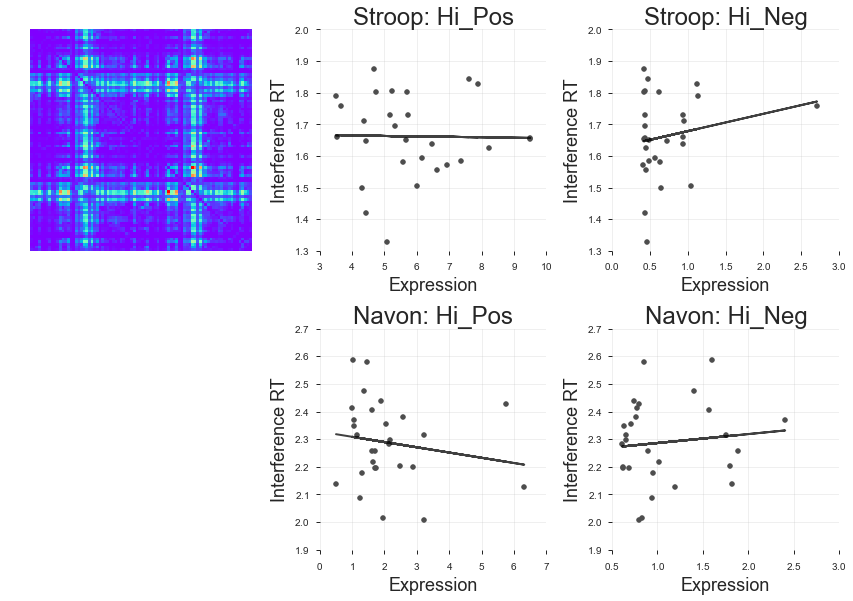





****************************** Subgraph 4 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

    Stroop: Hi_Pos: rho: -0.18610 pval: 0.34305 sig: 
    Stroop: Hi_Neg: rho: 0.02242 pval: 0.90983 sig: 
    Navon: Hi_Pos: rho: 0.14758 pval: 0.45359 sig: 
    Navon: Hi_Neg: rho: -0.09167 pval: 0.64269 sig: 


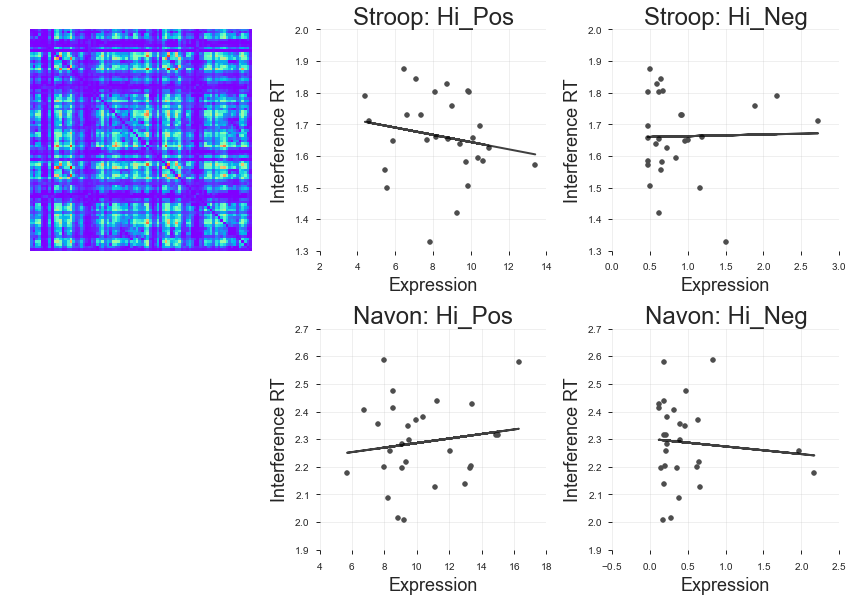





****************************** Subgraph 9 ******************************
    RH_frontalpole
    RH_lateralorbitofrontal
    LH_lateralorbitofrontal
    RH_parsorbitalis
    LH_frontalpole
    LH_parsorbitalis

    Stroop: Hi_Pos: rho: 0.15067 pval: 0.44409 sig: 
    Stroop: Hi_Neg: rho: 0.09531 pval: 0.62950 sig: 
    Navon: Hi_Pos: rho: -0.17901 pval: 0.36207 sig: 
    Navon: Hi_Neg: rho: -0.08000 pval: 0.68572 sig: 


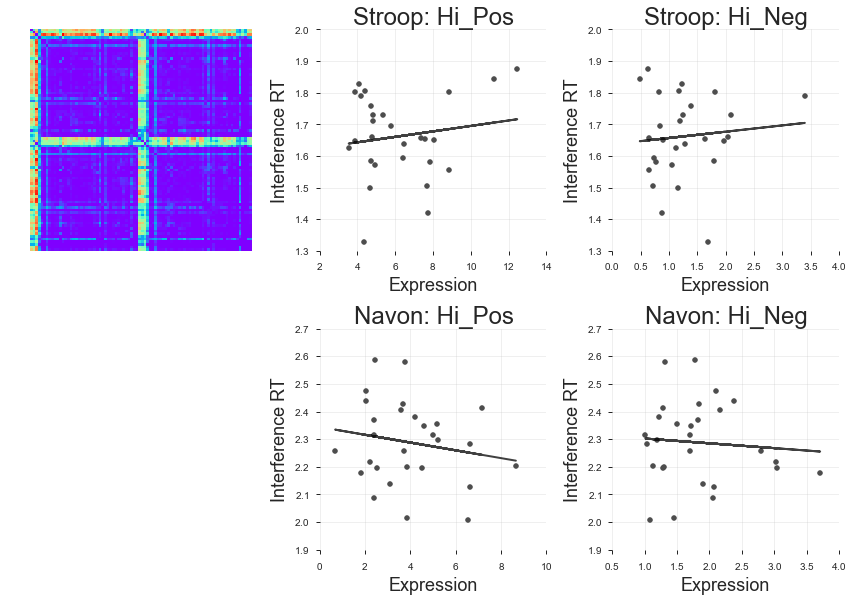





****************************** Subgraph 7 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

    Stroop: Hi_Pos: rho: 0.01862 pval: 0.92509 sig: 
    Stroop: Hi_Neg: rho: 0.04035 pval: 0.83847 sig: 
    Navon: Hi_Pos: rho: -0.04297 pval: 0.82810 sig: 
    Navon: Hi_Neg: rho: 0.17062 pval: 0.38536 sig: 


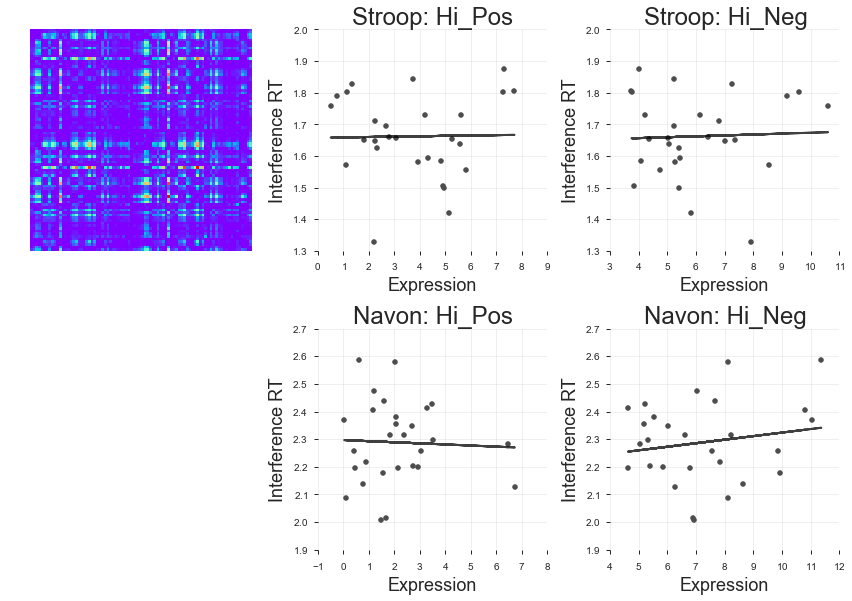





****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

    Stroop: Hi_Pos: rho: -0.14941 pval: 0.44795 sig: 
    Stroop: Hi_Neg: rho: 0.07535 pval: 0.70315 sig: 
    Navon: Hi_Pos: rho: 0.01599 pval: 0.93562 sig: 
    Navon: Hi_Neg: rho: -0.00222 pval: 0.99105 sig: 


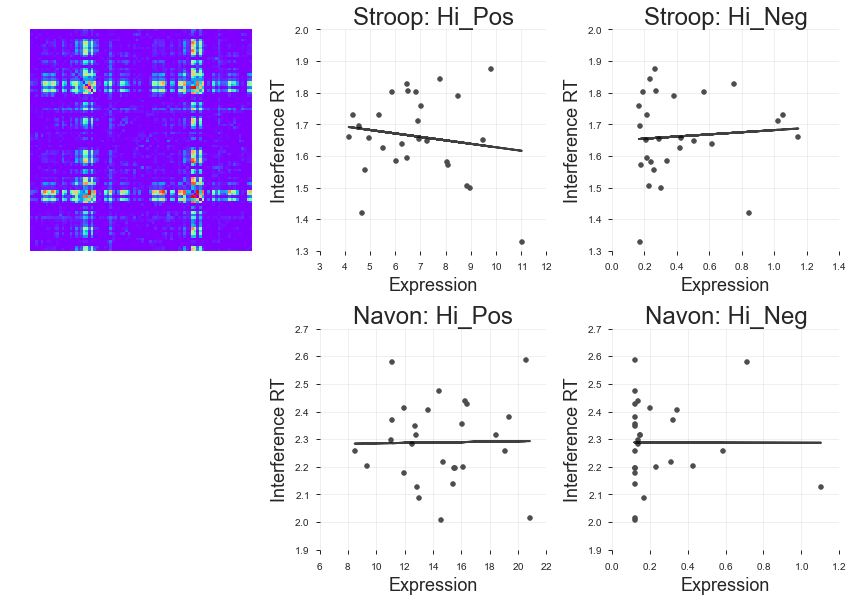

In [21]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf],
           'Navon': [navon_move, navon_interf]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting High Demand Condition RT (Hi-Lo)

****************************** Subgraph 8 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

     Stroop: Pos: rho: -0.05394 pval: 0.78515 sig: 
     Stroop: Neg: rho: -0.39802 pval: 0.03594 sig: 
      Navon: Pos: rho: -0.03713 pval: 0.85121 sig: 
      Navon: Neg: rho: 0.53350 pval: 0.00346 sig: 


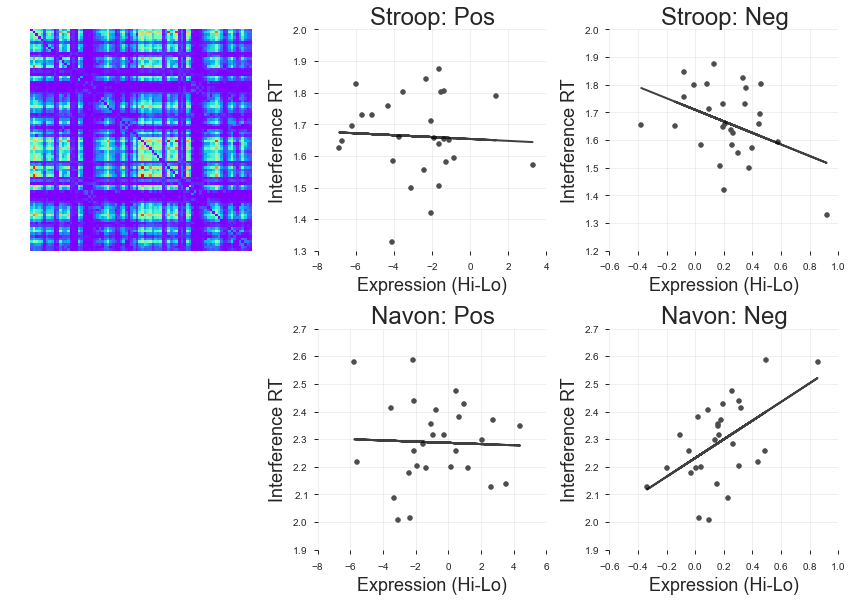





****************************** Subgraph 3 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

     Stroop: Pos: rho: -0.34015 pval: 0.07655 sig: 
     Stroop: Neg: rho: 0.51204 pval: 0.00534 sig: 
      Navon: Pos: rho: 0.48079 pval: 0.00960 sig: 
      Navon: Neg: rho: -0.24855 pval: 0.20217 sig: 


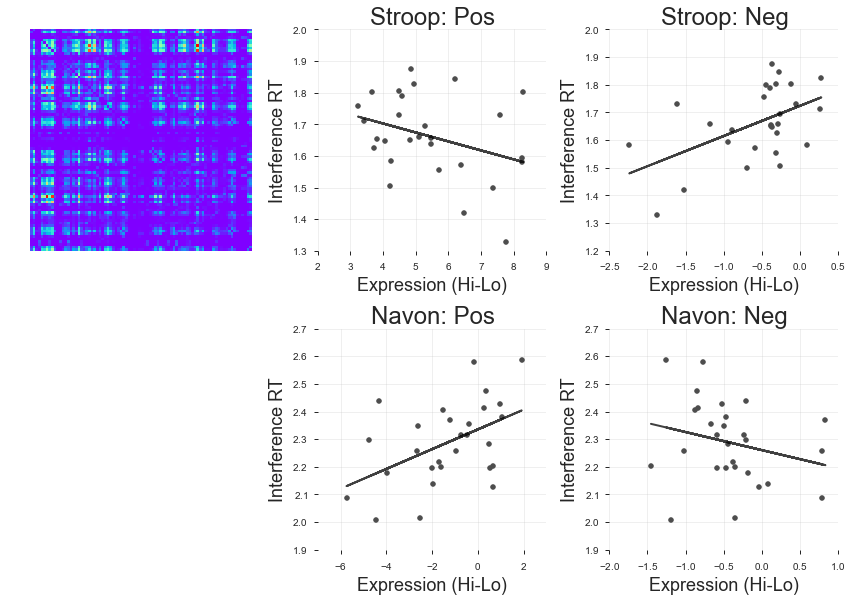





****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

     Stroop: Pos: rho: -0.02861 pval: 0.88509 sig: 
     Stroop: Neg: rho: 0.12037 pval: 0.54177 sig: 
      Navon: Pos: rho: 0.23579 pval: 0.22709 sig: 
      Navon: Neg: rho: 0.36249 pval: 0.05800 sig: 


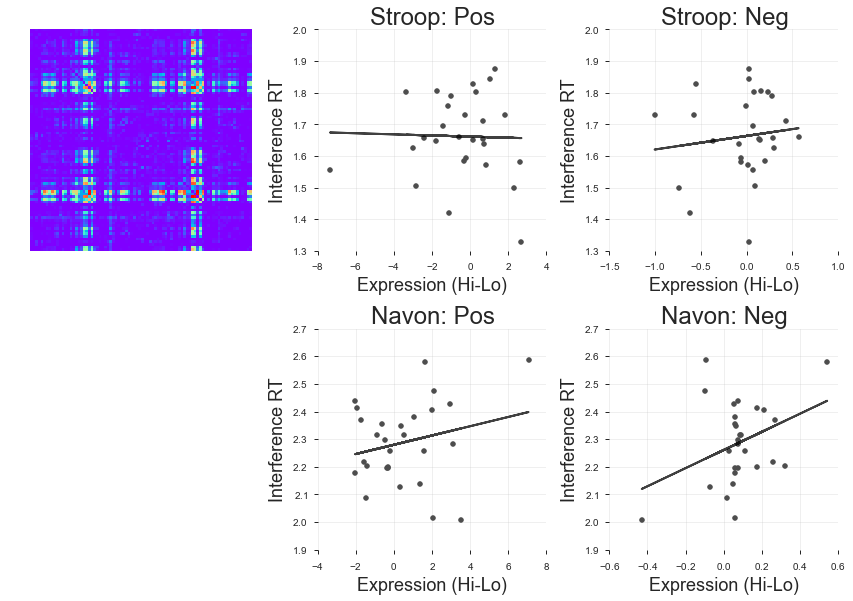





****************************** Subgraph 6 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

     Stroop: Pos: rho: -0.03359 pval: 0.86527 sig: 
     Stroop: Neg: rho: 0.27563 pval: 0.15571 sig: 
      Navon: Pos: rho: -0.00199 pval: 0.99198 sig: 
      Navon: Neg: rho: 0.33237 pval: 0.08398 sig: 


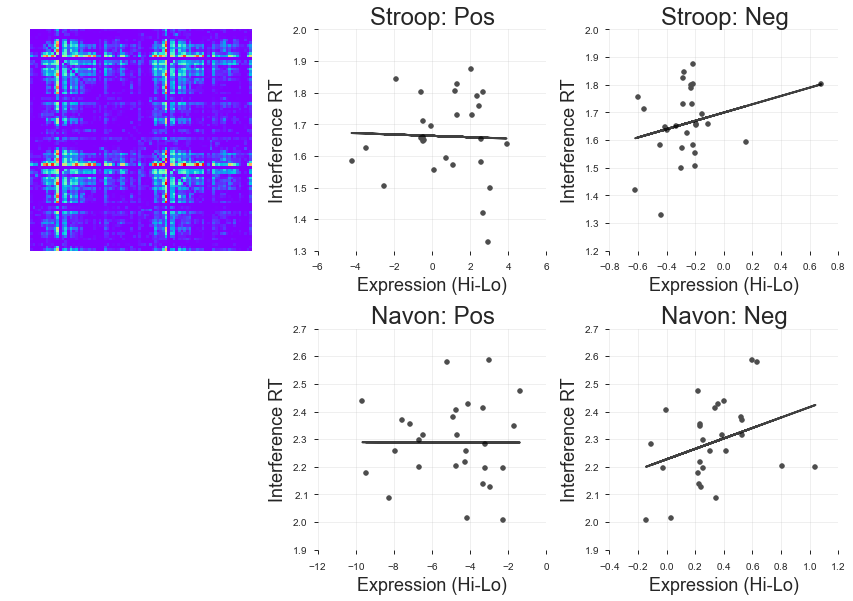





****************************** Subgraph 5 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

     Stroop: Pos: rho: -0.32402 pval: 0.09255 sig: 
     Stroop: Neg: rho: 0.09494 pval: 0.63082 sig: 
      Navon: Pos: rho: 0.27492 pval: 0.15682 sig: 
      Navon: Neg: rho: -0.08119 pval: 0.68130 sig: 


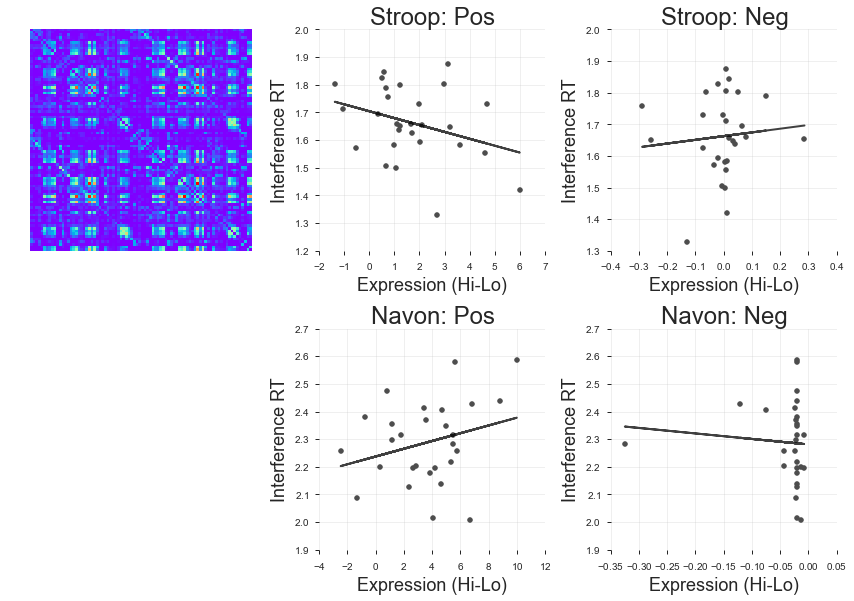





****************************** Subgraph 9 ******************************
    RH_frontalpole
    RH_lateralorbitofrontal
    LH_lateralorbitofrontal
    RH_parsorbitalis
    LH_frontalpole
    LH_parsorbitalis

     Stroop: Pos: rho: 0.12366 pval: 0.53069 sig: 
     Stroop: Neg: rho: -0.07926 pval: 0.68850 sig: 
      Navon: Pos: rho: -0.29170 pval: 0.13204 sig: 
      Navon: Neg: rho: 0.05730 pval: 0.77213 sig: 


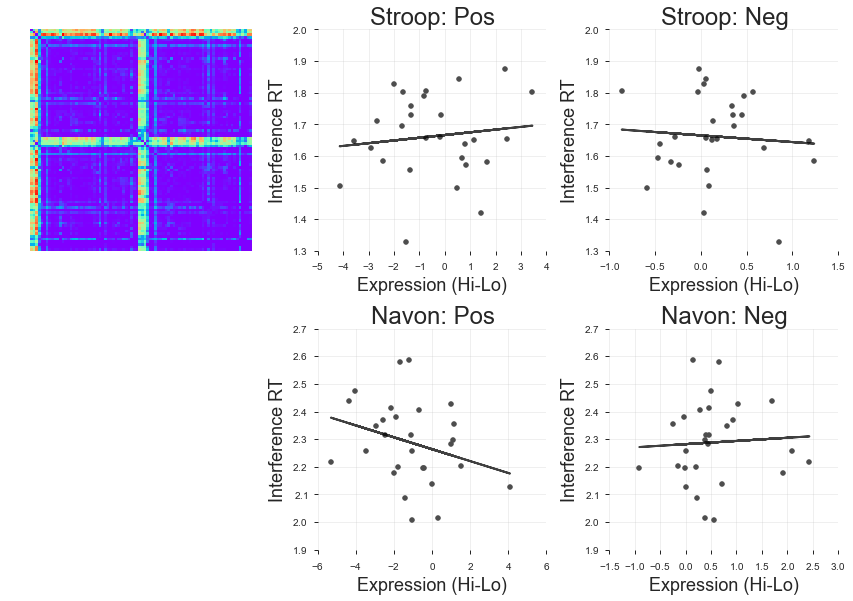





****************************** Subgraph 7 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

     Stroop: Pos: rho: 0.23238 pval: 0.23406 sig: 
     Stroop: Neg: rho: 0.05319 pval: 0.78806 sig: 
      Navon: Pos: rho: 0.03560 pval: 0.85727 sig: 
      Navon: Neg: rho: 0.22992 pval: 0.23919 sig: 


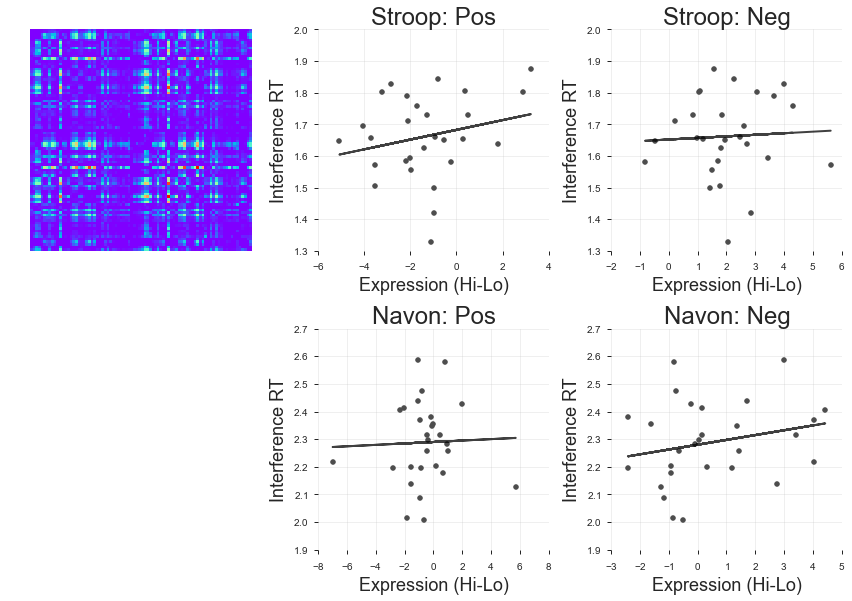





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

     Stroop: Pos: rho: 0.17229 pval: 0.38066 sig: 
     Stroop: Neg: rho: 0.07740 pval: 0.69545 sig: 
      Navon: Pos: rho: -0.22443 pval: 0.25091 sig: 
      Navon: Neg: rho: 0.11495 pval: 0.56026 sig: 


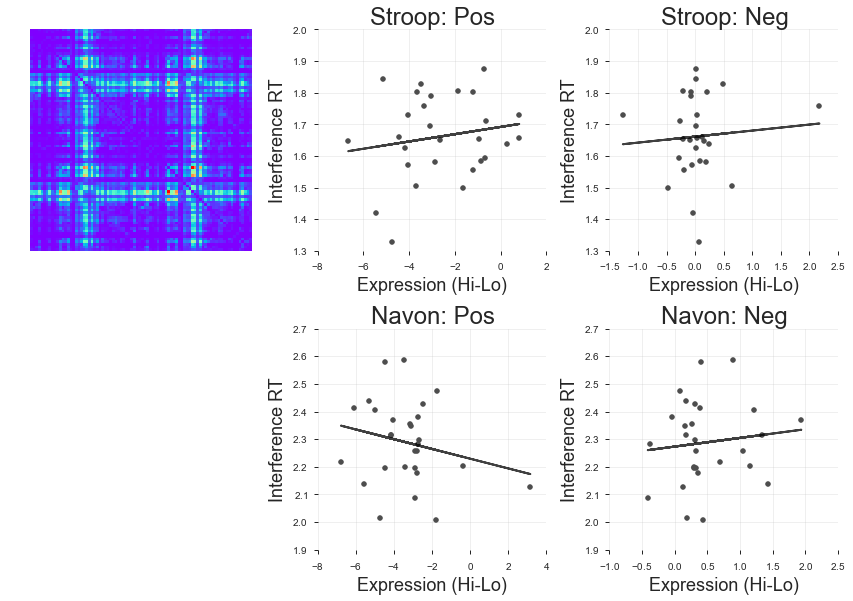





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

     Stroop: Pos: rho: -0.00994 pval: 0.95996 sig: 
     Stroop: Neg: rho: 0.00124 pval: 0.99502 sig: 
      Navon: Pos: rho: 0.17680 pval: 0.36812 sig: 
      Navon: Neg: rho: 0.04332 pval: 0.82673 sig: 


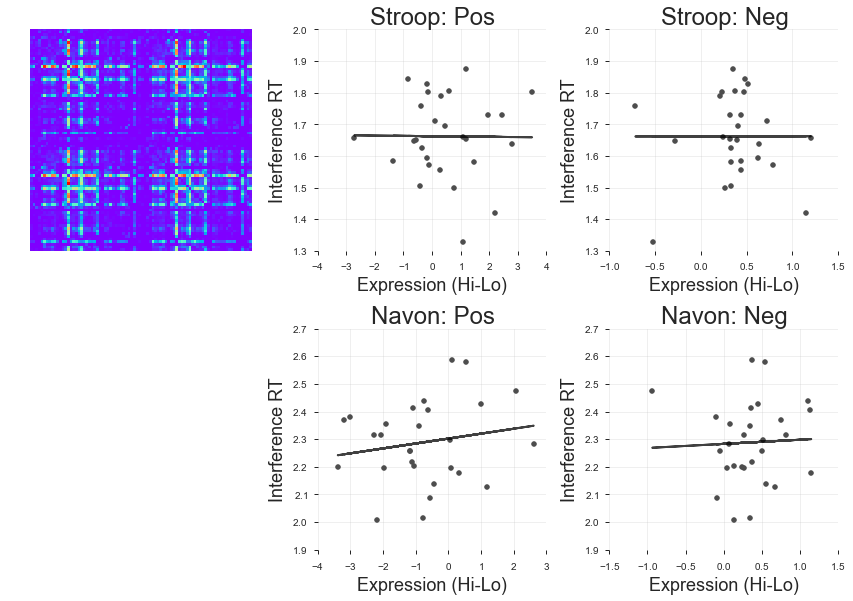





****************************** Subgraph 4 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

     Stroop: Pos: rho: 0.05203 pval: 0.79261 sig: 
     Stroop: Neg: rho: -0.08376 pval: 0.67174 sig: 
      Navon: Pos: rho: 0.03047 pval: 0.87766 sig: 
      Navon: Neg: rho: 0.03734 pval: 0.85038 sig: 


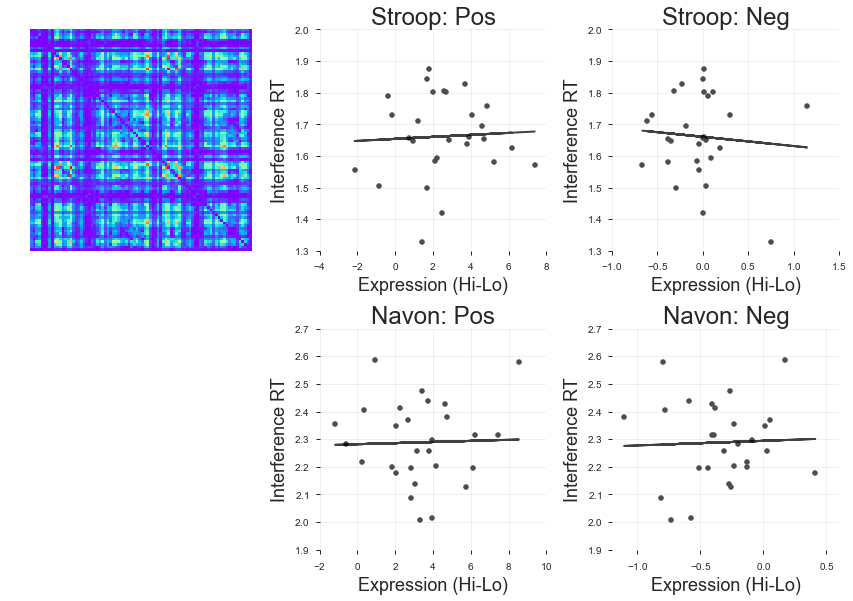

In [22]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf],
           'Navon': [navon_move, navon_interf]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting High Demand Condition Accuracy (Hi)

****************************** Subgraph 3 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

    Stroop: Hi_Pos: rho: -0.38618 pval: 0.04238 sig: 
    Stroop: Hi_Neg: rho: 0.01316 pval: 0.94701 sig: 
    Navon: Hi_Pos: rho: -0.41922 pval: 0.02638 sig: 
    Navon: Hi_Neg: rho: 0.31593 pval: 0.10147 sig: 


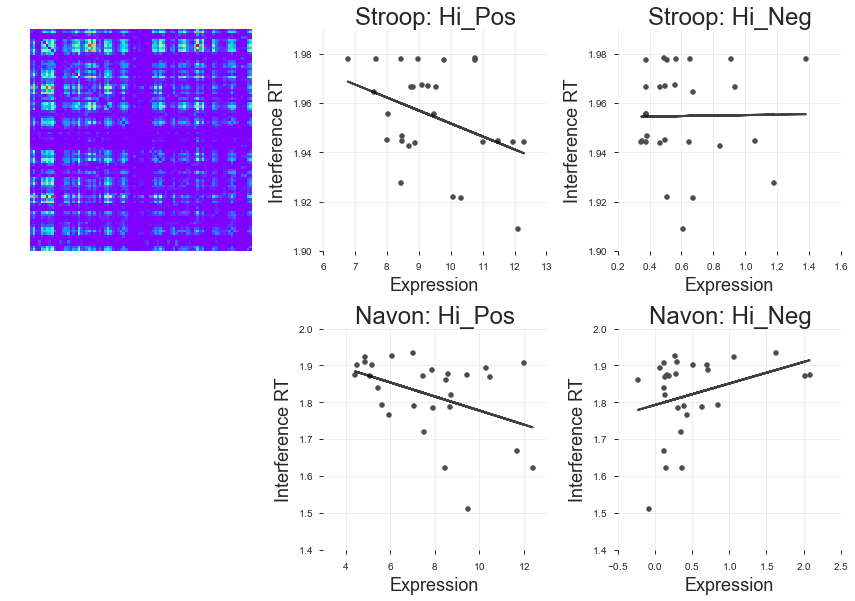





****************************** Subgraph 5 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

    Stroop: Hi_Pos: rho: 0.16803 pval: 0.39271 sig: 
    Stroop: Hi_Neg: rho: 0.32658 pval: 0.08985 sig: 
    Navon: Hi_Pos: rho: -0.02413 pval: 0.90301 sig: 
    Navon: Hi_Neg: rho: 0.09313 pval: 0.63738 sig: 


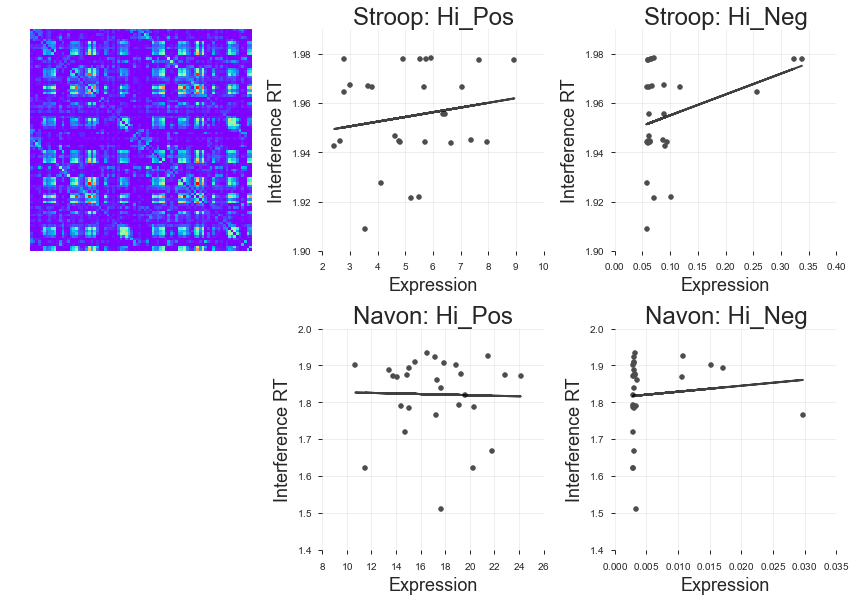





****************************** Subgraph 4 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

    Stroop: Hi_Pos: rho: 0.05444 pval: 0.78321 sig: 
    Stroop: Hi_Neg: rho: 0.17545 pval: 0.37185 sig: 
    Navon: Hi_Pos: rho: -0.03593 pval: 0.85596 sig: 
    Navon: Hi_Neg: rho: 0.28995 pval: 0.13448 sig: 


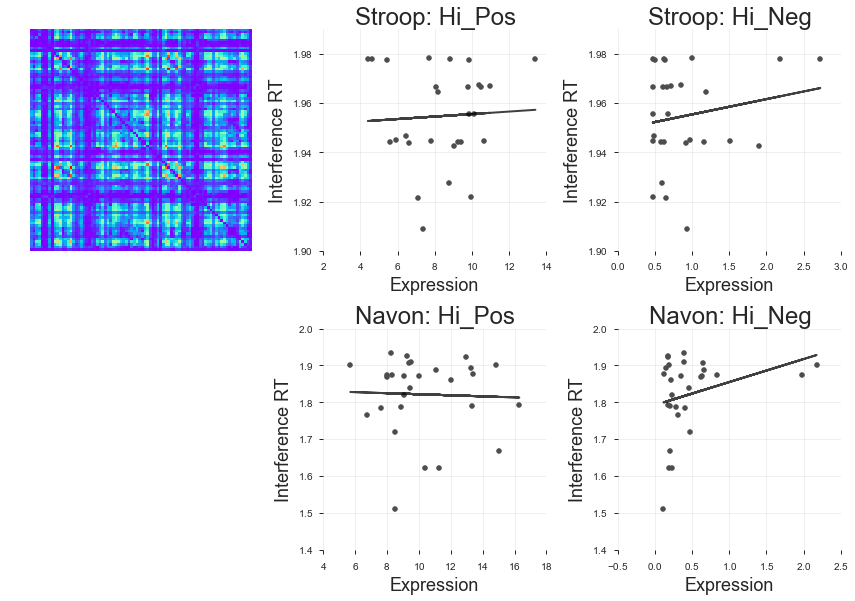





****************************** Subgraph 8 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

    Stroop: Hi_Pos: rho: 0.20727 pval: 0.28992 sig: 
    Stroop: Hi_Neg: rho: 0.12945 pval: 0.51148 sig: 
    Navon: Hi_Pos: rho: 0.28225 pval: 0.14561 sig: 
    Navon: Hi_Neg: rho: -0.11004 pval: 0.57722 sig: 


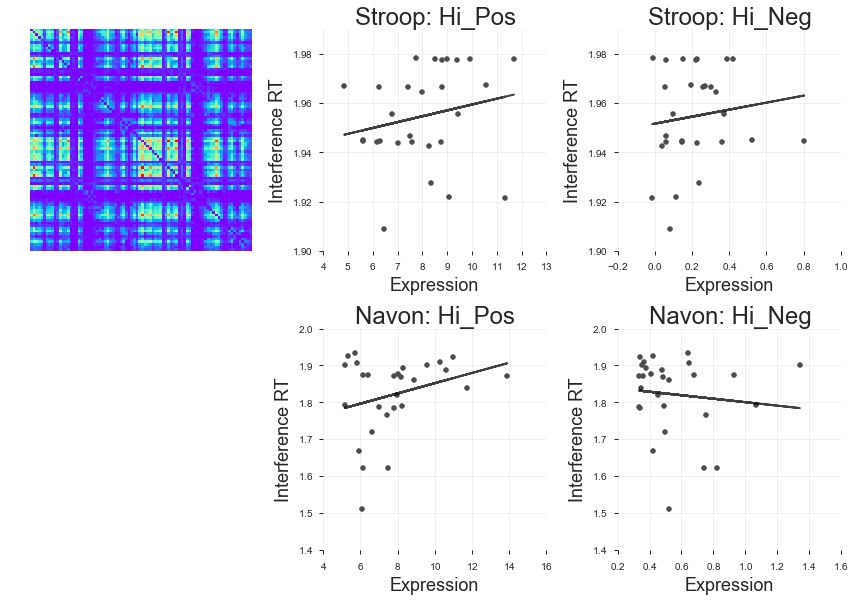





****************************** Subgraph 7 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

    Stroop: Hi_Pos: rho: -0.24319 pval: 0.21239 sig: 
    Stroop: Hi_Neg: rho: 0.19138 pval: 0.32927 sig: 
    Navon: Hi_Pos: rho: -0.09225 pval: 0.64059 sig: 
    Navon: Hi_Neg: rho: 0.27787 pval: 0.15223 sig: 


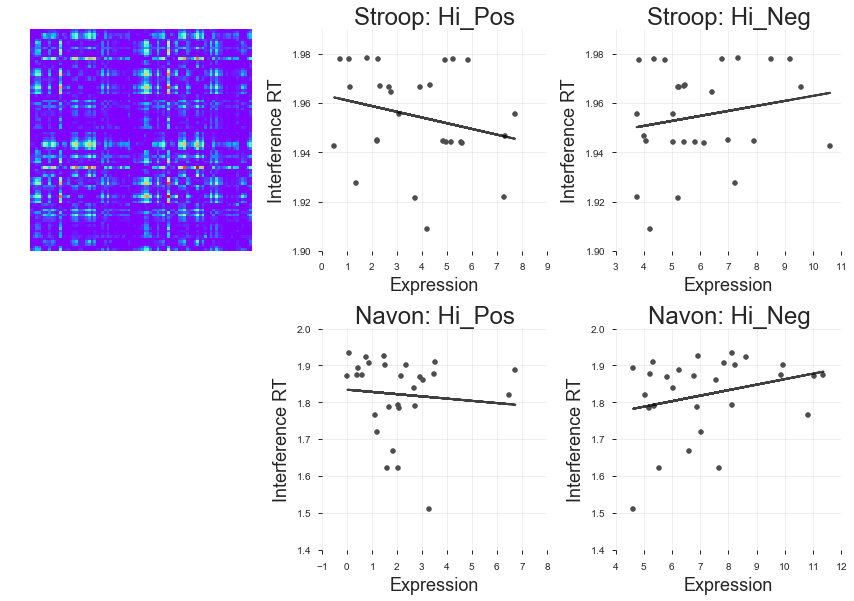





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: 0.04763 pval: 0.80980 sig: 
    Stroop: Hi_Neg: rho: -0.10995 pval: 0.57755 sig: 
    Navon: Hi_Pos: rho: 0.05990 pval: 0.76205 sig: 
    Navon: Hi_Neg: rho: 0.21324 pval: 0.27593 sig: 


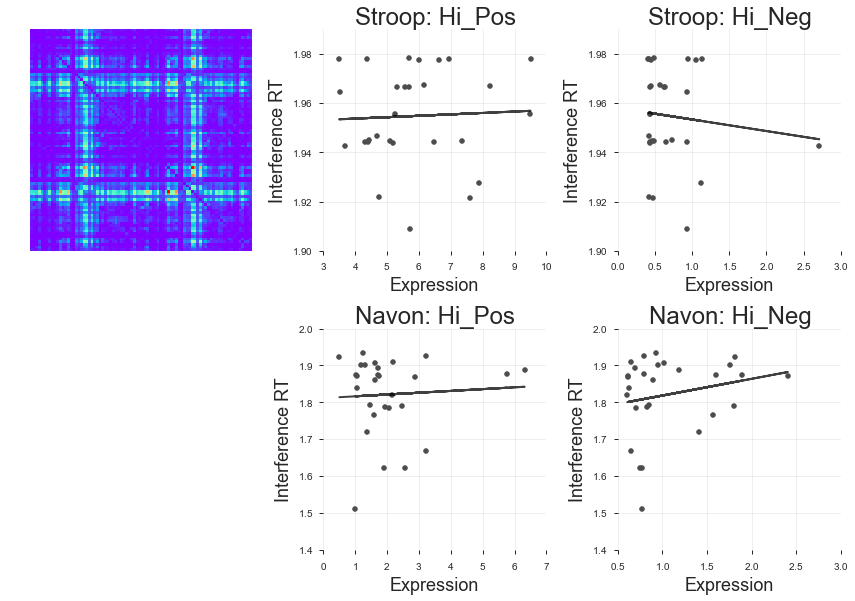





****************************** Subgraph 6 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

    Stroop: Hi_Pos: rho: -0.02853 pval: 0.88541 sig: 
    Stroop: Hi_Neg: rho: -0.10715 pval: 0.58734 sig: 
    Navon: Hi_Pos: rho: -0.20525 pval: 0.29476 sig: 
    Navon: Hi_Neg: rho: 0.05772 pval: 0.77050 sig: 


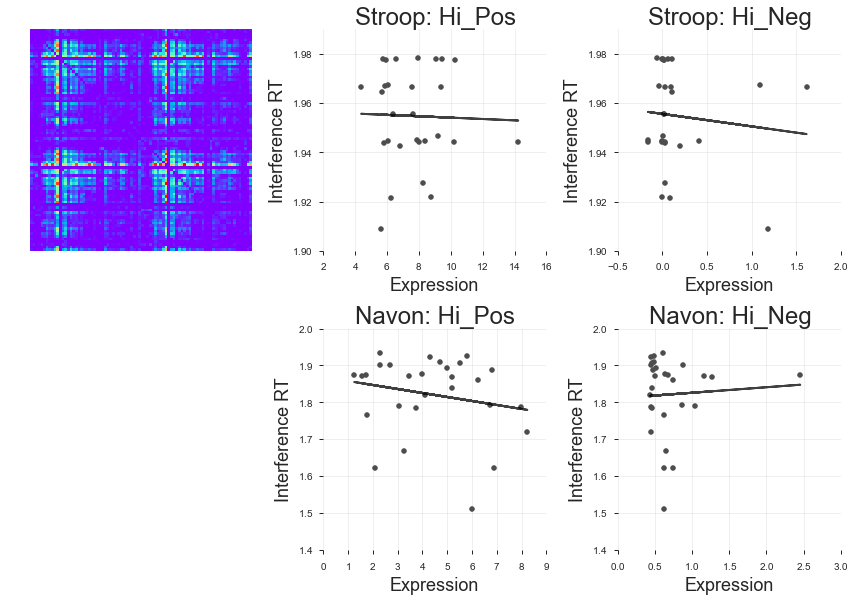





****************************** Subgraph 9 ******************************
    RH_frontalpole
    RH_lateralorbitofrontal
    LH_lateralorbitofrontal
    RH_parsorbitalis
    LH_frontalpole
    LH_parsorbitalis

    Stroop: Hi_Pos: rho: -0.08402 pval: 0.67078 sig: 
    Stroop: Hi_Neg: rho: 0.01616 pval: 0.93494 sig: 
    Navon: Hi_Pos: rho: -0.13000 pval: 0.50967 sig: 
    Navon: Hi_Neg: rho: 0.18058 pval: 0.35779 sig: 


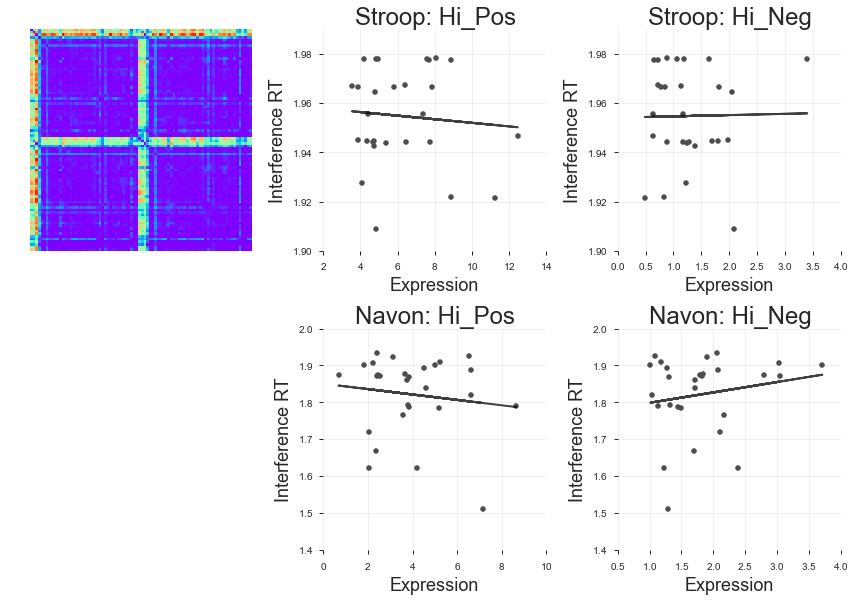





****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

    Stroop: Hi_Pos: rho: 0.07891 pval: 0.68979 sig: 
    Stroop: Hi_Neg: rho: -0.18035 pval: 0.35841 sig: 
    Navon: Hi_Pos: rho: -0.16989 pval: 0.38742 sig: 
    Navon: Hi_Neg: rho: 0.09143 pval: 0.64357 sig: 


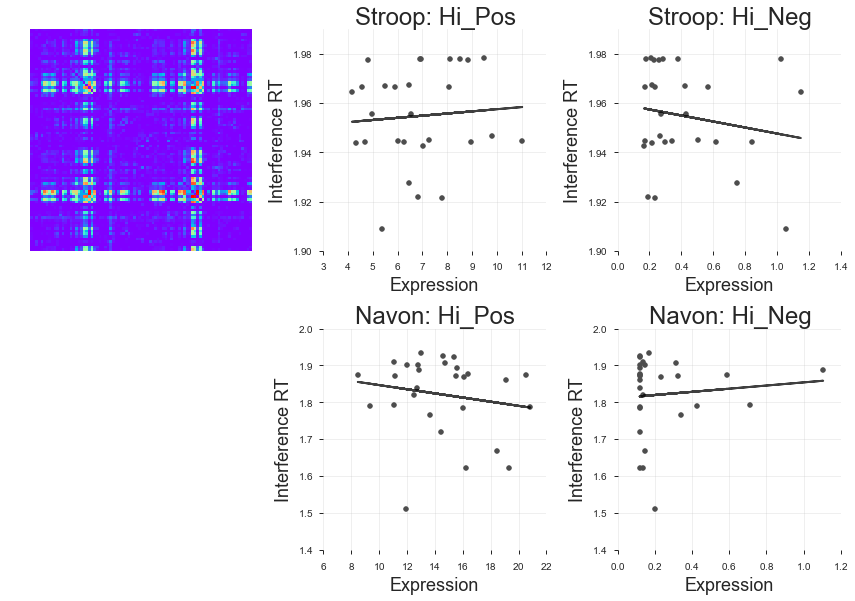





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

    Stroop: Hi_Pos: rho: 0.10408 pval: 0.59816 sig: 
    Stroop: Hi_Neg: rho: 0.02079 pval: 0.91638 sig: 
    Navon: Hi_Pos: rho: -0.10077 pval: 0.60992 sig: 
    Navon: Hi_Neg: rho: 0.10202 pval: 0.60544 sig: 


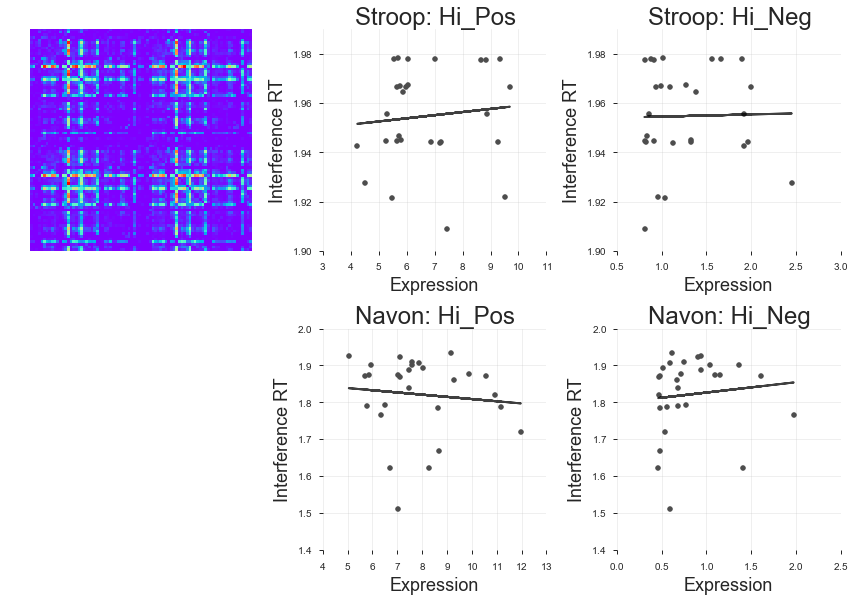

In [24]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_acc],
           'Navon': [navon_move, navon_acc]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting High Demand Condition Accuracy (Hi-Lo)

****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

     Stroop: Pos: rho: -0.37798 pval: 0.04735 sig: 
     Stroop: Neg: rho: 0.60761 pval: 0.00061 sig: *
      Navon: Pos: rho: 0.12188 pval: 0.53670 sig: 
      Navon: Neg: rho: -0.19862 pval: 0.31096 sig: 


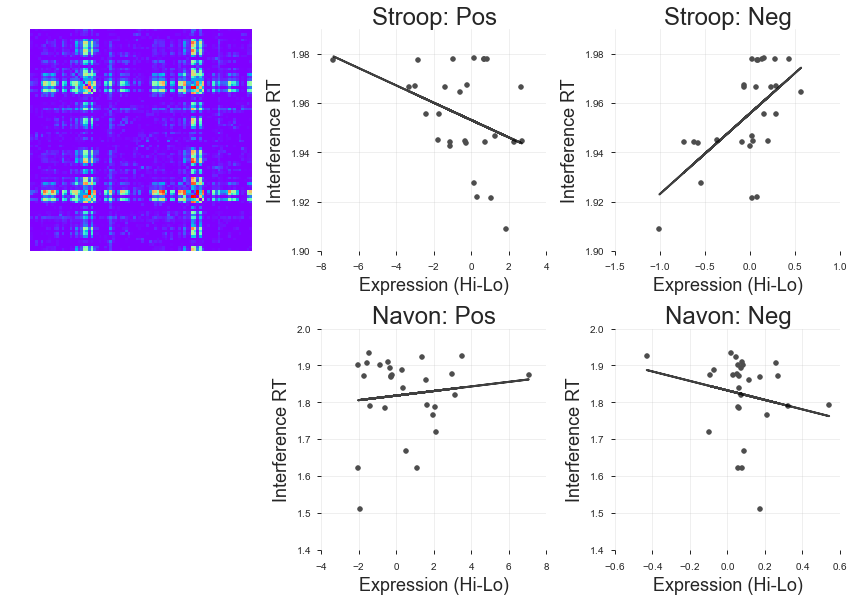





****************************** Subgraph 8 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

     Stroop: Pos: rho: 0.42948 pval: 0.02256 sig: 
     Stroop: Neg: rho: -0.00887 pval: 0.96428 sig: 
      Navon: Pos: rho: 0.17686 pval: 0.36796 sig: 
      Navon: Neg: rho: -0.09606 pval: 0.62680 sig: 


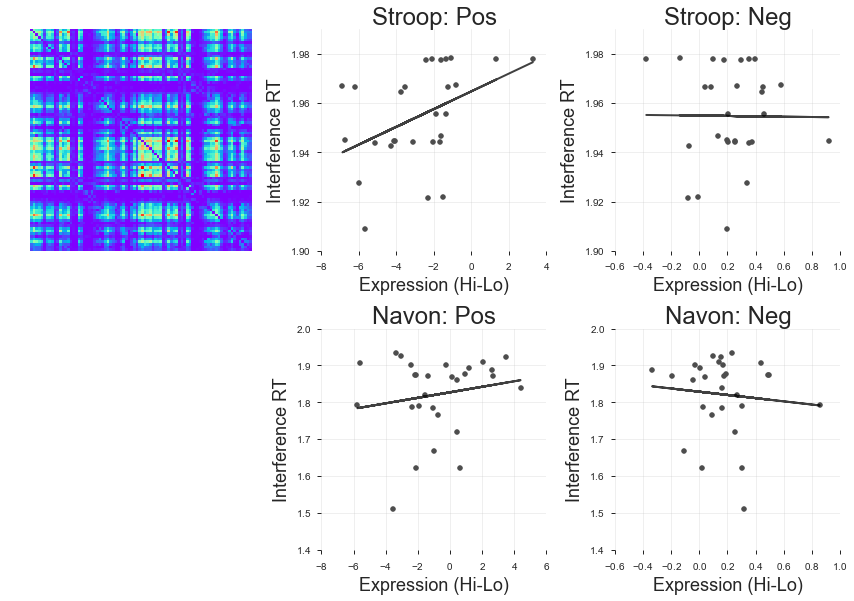





****************************** Subgraph 4 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

     Stroop: Pos: rho: -0.02086 pval: 0.91608 sig: 
     Stroop: Neg: rho: -0.12436 pval: 0.52836 sig: 
      Navon: Pos: rho: -0.08024 pval: 0.68481 sig: 
      Navon: Neg: rho: 0.34564 pval: 0.07162 sig: 


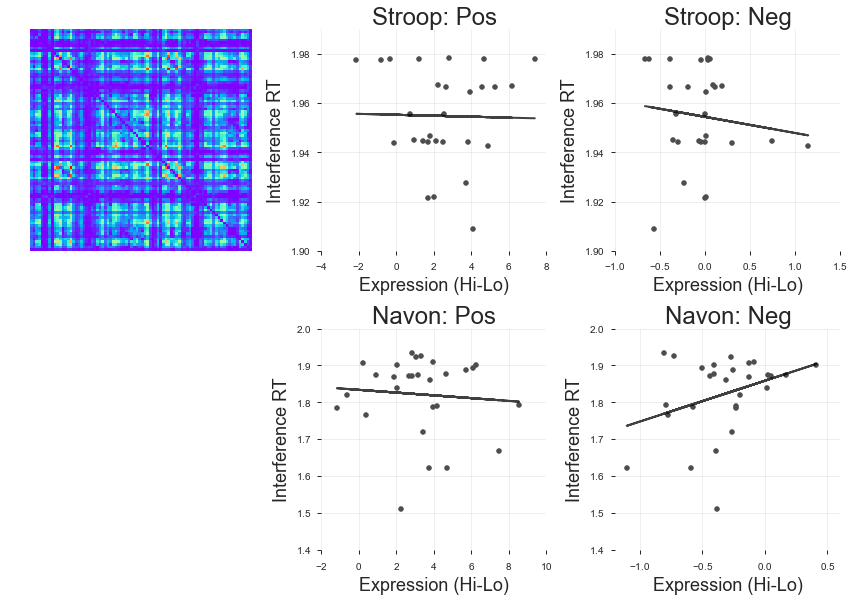





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

     Stroop: Pos: rho: -0.30262 pval: 0.11752 sig: 
     Stroop: Neg: rho: 0.11126 pval: 0.57299 sig: 
      Navon: Pos: rho: 0.09545 pval: 0.62899 sig: 
      Navon: Neg: rho: 0.09322 pval: 0.63706 sig: 


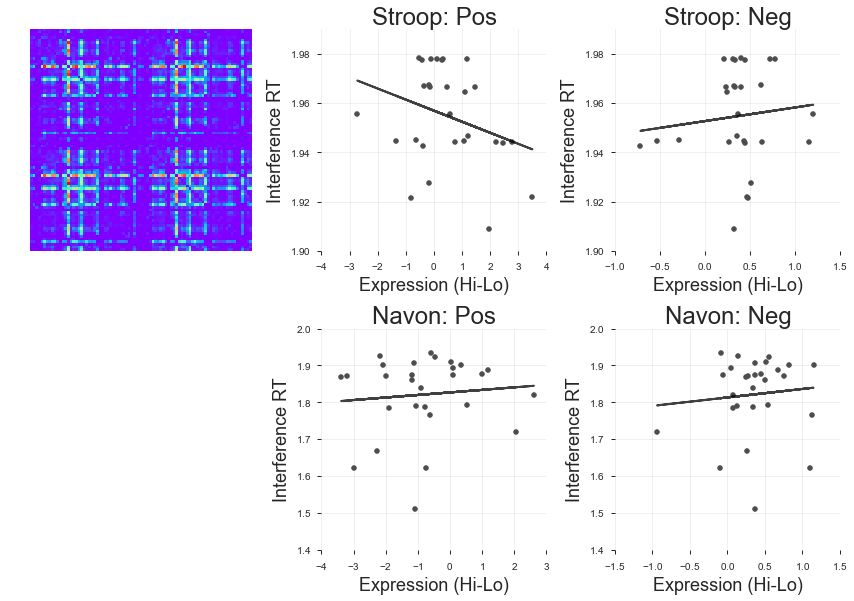





****************************** Subgraph 7 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

     Stroop: Pos: rho: -0.29587 pval: 0.12635 sig: 
     Stroop: Neg: rho: 0.08435 pval: 0.66957 sig: 
      Navon: Pos: rho: 0.07233 pval: 0.71453 sig: 
      Navon: Neg: rho: 0.15532 pval: 0.42998 sig: 


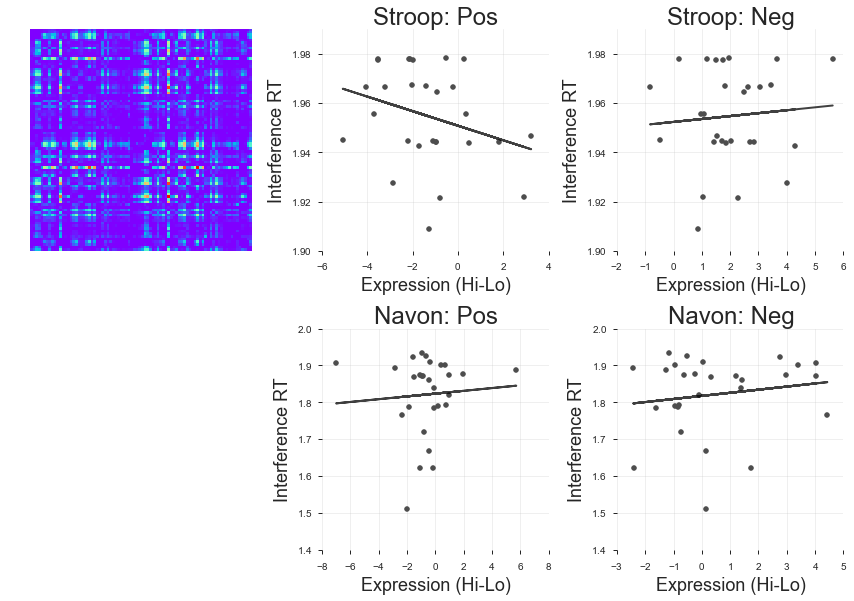





****************************** Subgraph 3 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

     Stroop: Pos: rho: -0.21716 pval: 0.26699 sig: 
     Stroop: Neg: rho: -0.01646 pval: 0.93373 sig: 
      Navon: Pos: rho: -0.29546 pval: 0.12689 sig: 
      Navon: Neg: rho: 0.28706 pval: 0.13858 sig: 


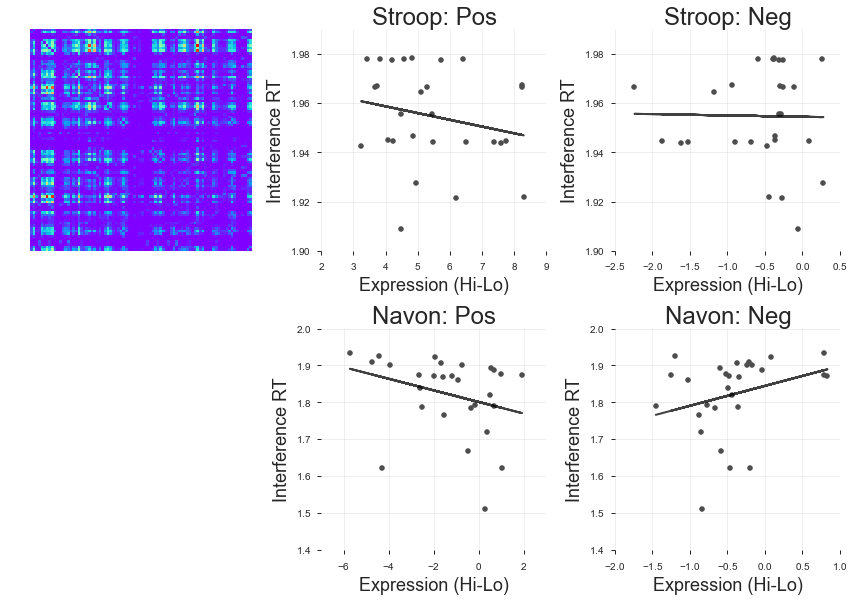





****************************** Subgraph 9 ******************************
    RH_frontalpole
    RH_lateralorbitofrontal
    LH_lateralorbitofrontal
    RH_parsorbitalis
    LH_frontalpole
    LH_parsorbitalis

     Stroop: Pos: rho: -0.16671 pval: 0.39651 sig: 
     Stroop: Neg: rho: -0.09198 pval: 0.64158 sig: 
      Navon: Pos: rho: 0.26486 pval: 0.17318 sig: 
      Navon: Neg: rho: 0.07535 pval: 0.70315 sig: 


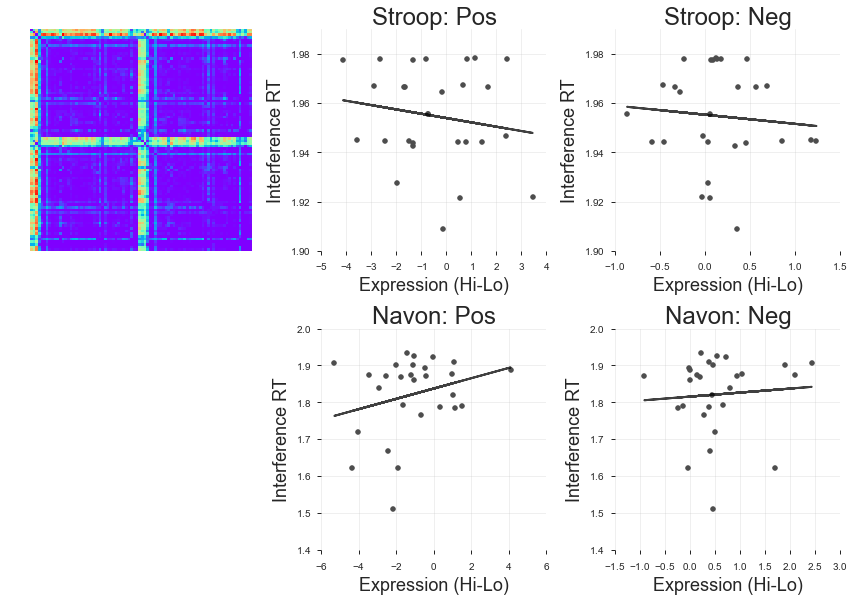





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

     Stroop: Pos: rho: -0.03126 pval: 0.87454 sig: 
     Stroop: Neg: rho: 0.05720 pval: 0.77250 sig: 
      Navon: Pos: rho: 0.25044 pval: 0.19866 sig: 
      Navon: Neg: rho: 0.21875 pval: 0.26341 sig: 


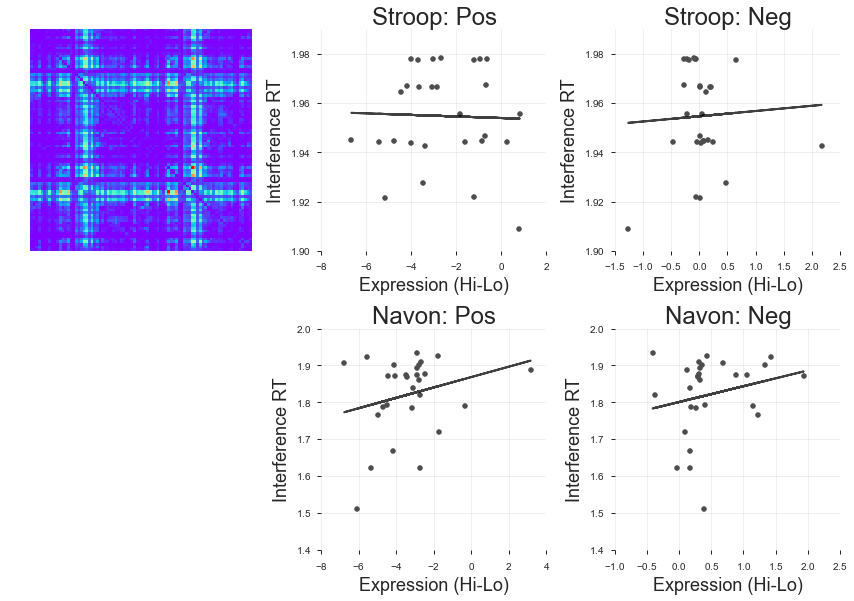





****************************** Subgraph 6 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

     Stroop: Pos: rho: -0.20548 pval: 0.29419 sig: 
     Stroop: Neg: rho: 0.19978 pval: 0.30807 sig: 
      Navon: Pos: rho: 0.03448 pval: 0.86172 sig: 
      Navon: Neg: rho: -0.10379 pval: 0.59918 sig: 


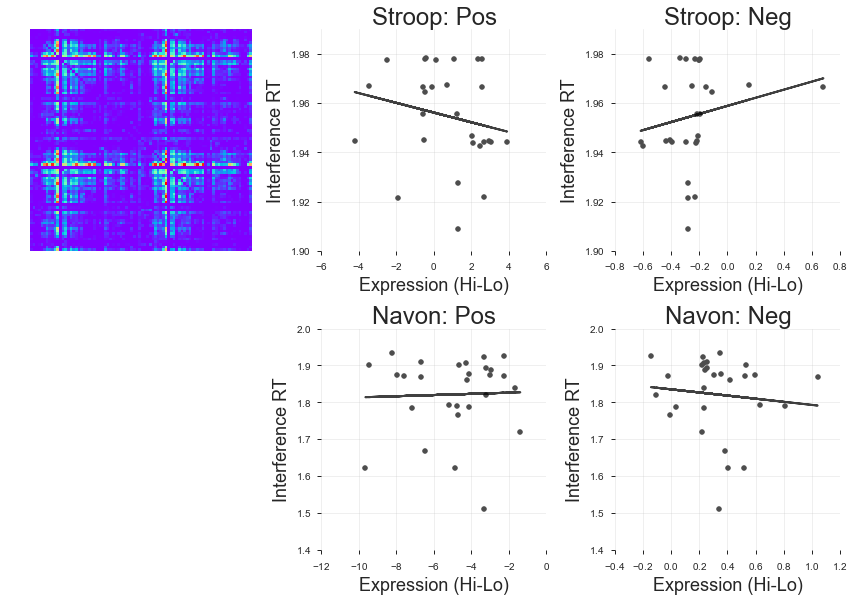





****************************** Subgraph 5 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

     Stroop: Pos: rho: -0.10168 pval: 0.60666 sig: 
     Stroop: Neg: rho: 0.10916 pval: 0.58029 sig: 
      Navon: Pos: rho: -0.04754 pval: 0.81016 sig: 
      Navon: Neg: rho: 0.00961 pval: 0.96130 sig: 


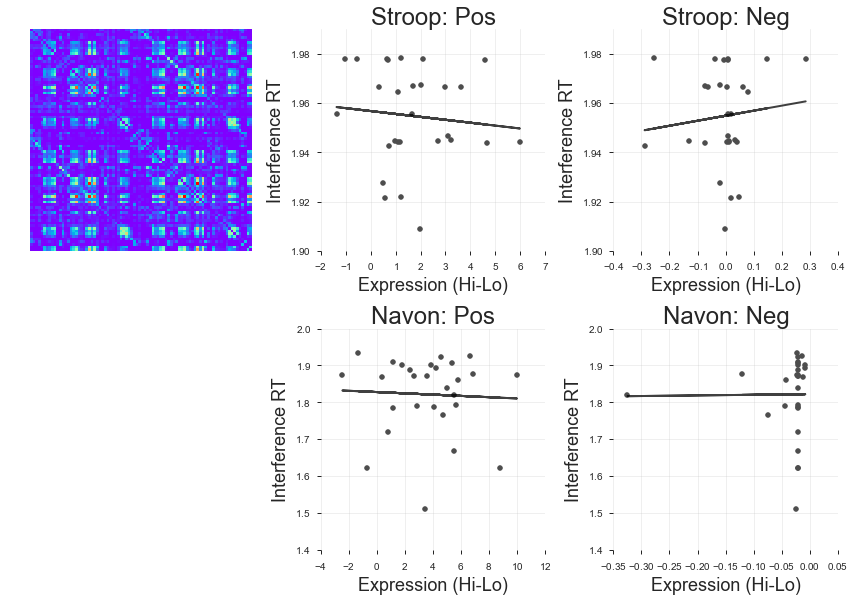

In [25]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_acc],
           'Navon': [navon_move, navon_acc]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')